i checked top-100 candidates of a sample images. activation values are > 0.95 for each candidates.

i think the prob which this model gives can't be a prob of nodule/nonnodule.

i have to toss it to detect model.

In [2]:
import numpy as np 
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D

Using Theano backend.
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN not available)


In [4]:
import sys, os
sys.path.append(os.path.join(sys.path[0],'screeningmodel'))

from scripts.plotArray import plotArray, plotArrayWithbBox
from customNetwork.custom import customModel, projectedCenter

Screening

In [5]:
screeningmodel=customModel(free=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, None, None, 64 640         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
act1 (Activation)                (None, None, None, 64 0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, None, None, 64 0           act1[0][0]                       
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, None, 64 36928       pool1[0][0]                      
___________________________________________________________________________________________

In [6]:
screeningmodel.load_weights('/home/sdyang/Desktop/pythonfiles/LIDC/screening/weights22.hdf5')

In [7]:
import dicom
#pydicom is imported as 'dicom'
import numpy
import numpy as np
import os
from matplotlib import pyplot, cm
from tqdm import tqdm

In [8]:
cd /home/sdyang/Desktop/LIDC/data/twopointFive/benignslices/

/home/sdyang/Desktop/LIDC/data/twopointFive/benignslices


In [194]:
#cd /home/sdyang/Desktop/LIDC/data/twopointFive/malignslices/

In [9]:
import pickle
with open("/home/sdyang/Desktop/LIDC/exports/benign_entroids.p","rb") as input_data:
    centroids_label=pickle.load(input_data, encoding='bytes')

In [ ]:
import pickle
with open("/home/sdyang/Desktop/LIDC/exports/malign_entroids.p","rb") as input_data:
    centroids_label=pickle.load(input_data, encoding='bytes')

In [10]:
PathDicom = "./"

#initialize
test=centroids_label[0]
testdicom=PathDicom+test[0]+'.dcm'

RefDs = dicom.read_file(testdicom)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(centroids_label))
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

for i in tqdm(range(len(centroids_label))):
    cent=centroids_label[i]
    dicomfile=PathDicom+cent[0]+'.dcm'
    ds = dicom.read_file(dicomfile)
    ArrayDicom[:, :, i] = ds.pixel_array

100%|██████████| 1473/1473 [00:09<00:00, 155.64it/s]


In [195]:
len(centroids_label)

Fine tuning with Fps in screening model

In [198]:
import pickle
#with open("G:/Jupyter_python/Beom/170210/exported/centroids.p","rb") as input_data:
#    centroids_label=pickle.load(input_data, encoding='bytes')

with open("G:/Jupyter_python/Beom/170210/exported/centroidsMalignant.p","rb") as input_data:
    centroids_label=pickle.load(input_data, encoding='bytes')

In [12]:
len(centroids_label)

1473

In [11]:
dataset_tune=np.zeros((1,50,50))

In [19]:
nb_test=len(centroids_label)
for i in tqdm(range(nb_test)):
    testnumber=i
    testimage=ArrayDicom[:,:,testnumber].reshape(1,512,512,1)/1000
    prediction=screeningmodel.predict(testimage)
    #predictedlabel=np.argmax(prediction,axis=3)

    #i have to change this candidate measure.

    tt=np.sort(prediction[0,:,:,0],axis=None)
    tt2=tt[::-1]
    xindices=np.where(prediction[0,:,:,0]>tt2[10])[0]
    yindices=np.where(prediction[0,:,:,0]>tt2[10])[1]

    kk=projectedCenter(xindices,yindices)
    xCoord, yCoord = kk

    for l, k in zip(xCoord,yCoord):
        if abs(l-centroids_label[i][1][0])>60 or abs(k-centroids_label[i][1][1])>60:
            print((l,k))
            try:
                dataset_tune=np.vstack((dataset_tune,ArrayDicom[int(np.floor(l))-25:int(np.floor(l))+25,int(np.floor(k))-25:int(np.floor(k))+25,i].reshape(1,50,50)))
            except Exception as e:
                print(np.floor(l))
                print(e)
                print(l)
                print(k)
                print("="*50)


  0%|          | 4/1473 [00:00<00:45, 32.64it/s]

(286.5, 206.5)
(286.5, 310.5)
(286.5, 326.5)
(302.5, 214.5)
(302.5, 222.5)
(310.5, 158.5)
(310.5, 166.5)
(310.5, 206.5)
(318.5, 158.5)
(318.5, 206.5)
(286.5, 206.5)
(302.5, 214.5)
(302.5, 222.5)
(318.5, 190.5)
(302.5, 230.5)
(302.5, 230.5)
(206.5, 214.5)
(206.5, 222.5)
(214.5, 206.5)
(214.5, 214.5)
(214.5, 222.5)
(214.5, 230.5)
(222.5, 206.5)
(222.5, 214.5)
(222.5, 222.5)
(222.5, 230.5)
(206.5, 214.5)
(206.5, 222.5)
(206.5, 230.5)
(214.5, 214.5)
(214.5, 222.5)
(214.5, 230.5)
(222.5, 206.5)
(222.5, 214.5)
(222.5, 222.5)
(222.5, 230.5)


  1%|          | 12/1473 [00:00<00:46, 31.75it/s]

(206.5, 206.5)
(206.5, 214.5)
(206.5, 222.5)
(214.5, 206.5)
(214.5, 214.5)
(214.5, 222.5)
(214.5, 230.5)
(222.5, 206.5)
(222.5, 214.5)
(222.5, 222.5)
(182.5, 302.5)
(190.5, 302.5)
(190.5, 318.5)
(198.5, 302.5)
(198.5, 318.5)
(206.5, 302.5)
(262.5, 310.5)
(182.5, 302.5)
(190.5, 302.5)
(190.5, 318.5)
(198.5, 302.5)
(198.5, 318.5)
(206.5, 302.5)
(262.5, 310.5)
(294.5, 190.5)
(294.5, 206.5)
(302.5, 206.5)
(214.5, 318.5)
(214.5, 326.5)
(222.5, 310.5)
(222.5, 318.5)
(206.5, 206.5)
(286.5, 182.5)


  2%|▏         | 24/1473 [00:00<00:45, 31.76it/s]

(206.5, 326.5)
(254.5, 174.5)
(262.5, 182.5)
(310.5, 326.5)
(358.5, 182.5)
(222.5, 182.5)
(318.5, 166.5)
(318.5, 174.5)
(318.5, 182.5)
(190.5, 142.5)
(198.5, 142.5)
(214.5, 174.5)
(222.5, 158.5)
(222.5, 174.5)
(246.5, 358.5)
(254.5, 350.5)
(254.5, 358.5)
(238.5, 398.5)
(238.5, 406.5)
(318.5, 134.5)
(318.5, 142.5)
(318.5, 150.5)
(326.5, 134.5)
(326.5, 142.5)
(326.5, 150.5)
(334.5, 318.5)
(334.5, 326.5)
(230.5, 398.5)
(230.5, 406.5)
(238.5, 390.5)
(238.5, 398.5)
(238.5, 406.5)
(246.5, 390.5)
(246.5, 398.5)
(246.5, 406.5)
(326.5, 134.5)
(334.5, 326.5)
(310.5, 134.5)
(310.5, 142.5)
(318.5, 134.5)
(318.5, 142.5)
(318.5, 150.5)
(326.5, 134.5)
(326.5, 142.5)
(326.5, 150.5)
(334.5, 134.5)
(334.5, 150.5)
(254.5, 366.5)
(254.5, 374.5)
(262.5, 366.5)
(262.5, 374.5)
(262.5, 382.5)
(318.5, 134.5)
(318.5, 142.5)
(326.5, 134.5)
(326.5, 142.5)
(334.5, 150.5)


  2%|▏         | 30/1473 [00:00<00:48, 29.91it/s]

(262.5, 366.5)
(262.5, 374.5)
(270.5, 366.5)
(270.5, 374.5)
(286.5, 398.5)
(286.5, 406.5)
(286.5, 414.5)
(294.5, 198.5)
(294.5, 214.5)
(294.5, 406.5)
(270.5, 334.5)
(278.5, 318.5)
(278.5, 326.5)
(278.5, 334.5)
(398.5, 302.5)
(406.5, 302.5)
(406.5, 310.5)
(406.5, 318.5)
(414.5, 310.5)
(414.5, 318.5)
(286.5, 142.5)
(398.5, 302.5)
(398.5, 310.5)
(398.5, 318.5)
(406.5, 302.5)
(406.5, 310.5)
(406.5, 318.5)
(414.5, 302.5)
(414.5, 310.5)
(414.5, 318.5)
(198.5, 334.5)
(262.5, 326.5)
(342.5, 198.5)
(350.5, 198.5)
(358.5, 198.5)
(366.5, 174.5)
(406.5, 302.5)
(414.5, 302.5)
(414.5, 310.5)
(414.5, 318.5)
(310.5, 190.5)
(334.5, 358.5)
(334.5, 366.5)
(390.5, 118.5)
(390.5, 126.5)
(398.5, 118.5)
(398.5, 126.5)
(398.5, 134.5)
(406.5, 118.5)
(406.5, 126.5)
(310.5, 182.5)
(310.5, 190.5)
(318.5, 182.5)
(318.5, 190.5)
(358.5, 198.5)
(374.5, 166.5)
(390.5, 118.5)
(398.5, 118.5)
(398.5, 126.5)
(406.5, 118.5)


  2%|▏         | 36/1473 [00:01<00:48, 29.42it/s]

(198.5, 198.5)
(206.5, 174.5)
(206.5, 198.5)
(214.5, 174.5)
(214.5, 182.5)
(214.5, 190.5)
(214.5, 198.5)
(222.5, 142.5)
(222.5, 150.5)
(230.5, 182.5)
(246.5, 166.5)
(254.5, 166.5)
(318.5, 262.5)
(174.5, 206.5)
(182.5, 190.5)
(182.5, 206.5)
(190.5, 206.5)
(198.5, 198.5)
(206.5, 182.5)
(206.5, 198.5)
(214.5, 198.5)
(342.5, 182.5)
(350.5, 182.5)
(278.5, 334.5)
(310.5, 262.5)
(310.5, 270.5)
(318.5, 270.5)
(158.5, 206.5)
(166.5, 206.5)
(294.5, 78.5)
(302.5, 78.5)
(310.5, 78.5)
(358.5, 142.5)
(366.5, 142.5)
(366.5, 150.5)
(366.5, 158.5)
(158.5, 206.5)
(278.5, 334.5)


  3%|▎         | 39/1473 [00:01<00:51, 28.03it/s]

(230.5, 174.5)
(238.5, 174.5)
(238.5, 182.5)
(246.5, 182.5)
(238.5, 206.5)
(246.5, 206.5)
(254.5, 206.5)
(262.5, 198.5)
(262.5, 206.5)
(262.5, 214.5)
(270.5, 206.5)
(270.5, 358.5)
(310.5, 342.5)
(310.5, 350.5)
(190.5, 246.5)
(198.5, 246.5)
(238.5, 206.5)
(238.5, 214.5)
(246.5, 206.5)
(246.5, 214.5)
(254.5, 206.5)
(262.5, 198.5)
(262.5, 206.5)
(270.5, 358.5)
(230.5, 198.5)
(254.5, 318.5)
(326.5, 334.5)
(342.5, 334.5)
(350.5, 334.5)
(270.5, 182.5)
(286.5, 110.5)
(286.5, 118.5)
(286.5, 182.5)
(286.5, 374.5)
(294.5, 110.5)
(294.5, 118.5)
(294.5, 358.5)
(294.5, 366.5)
(294.5, 374.5)


  3%|▎         | 45/1473 [00:01<00:56, 25.49it/s]

(246.5, 358.5)
(246.5, 366.5)
(246.5, 374.5)
(254.5, 358.5)
(254.5, 374.5)
(262.5, 358.5)
(262.5, 366.5)
(262.5, 374.5)
(270.5, 182.5)
(286.5, 182.5)
(334.5, 198.5)
(326.5, 198.5)
(326.5, 206.5)
(334.5, 190.5)
(334.5, 198.5)
(334.5, 206.5)
(270.5, 206.5)


  3%|▎         | 51/1473 [00:01<00:57, 24.91it/s]

(310.5, 286.5)
(318.5, 278.5)
(318.5, 286.5)
(318.5, 294.5)
(326.5, 278.5)
(326.5, 286.5)
(326.5, 294.5)
(310.5, 286.5)
(310.5, 294.5)
(318.5, 278.5)
(318.5, 286.5)
(326.5, 278.5)
(326.5, 286.5)
(326.5, 294.5)
(334.5, 278.5)
(318.5, 278.5)
(318.5, 286.5)
(318.5, 294.5)
(326.5, 278.5)
(326.5, 286.5)
(326.5, 294.5)
(334.5, 278.5)
(334.5, 286.5)
(334.5, 294.5)
(342.5, 278.5)
(318.5, 278.5)
(318.5, 286.5)
(326.5, 278.5)
(326.5, 286.5)
(326.5, 294.5)
(334.5, 278.5)
(334.5, 286.5)
(342.5, 278.5)
(342.5, 286.5)
(350.5, 286.5)
(318.5, 294.5)
(326.5, 278.5)
(326.5, 286.5)
(326.5, 302.5)
(334.5, 278.5)
(334.5, 286.5)
(334.5, 294.5)
(334.5, 302.5)
(342.5, 278.5)
(342.5, 286.5)


  4%|▍         | 57/1473 [00:02<01:02, 22.79it/s]

(294.5, 278.5)
(294.5, 286.5)
(302.5, 278.5)
(302.5, 286.5)
(310.5, 278.5)
(310.5, 286.5)
(318.5, 286.5)
(326.5, 286.5)
(334.5, 286.5)
(334.5, 294.5)
(342.5, 286.5)
(350.5, 270.5)
(350.5, 278.5)
(350.5, 286.5)
(358.5, 270.5)
(358.5, 278.5)
(358.5, 286.5)
(326.5, 286.5)
(334.5, 286.5)
(342.5, 286.5)
(350.5, 270.5)
(350.5, 278.5)
(350.5, 286.5)
(358.5, 270.5)
(358.5, 278.5)
(358.5, 286.5)
(358.5, 294.5)
(310.5, 270.5)
(310.5, 278.5)
(318.5, 262.5)
(318.5, 270.5)
(318.5, 278.5)
(326.5, 270.5)
(326.5, 278.5)
(350.5, 270.5)
(358.5, 270.5)
(358.5, 278.5)
(254.5, 190.5)
(254.5, 198.5)
(254.5, 206.5)
(254.5, 214.5)
(262.5, 190.5)
(262.5, 198.5)


  4%|▍         | 63/1473 [00:02<01:02, 22.50it/s]

(254.5, 198.5)
(254.5, 214.5)
(254.5, 198.5)
(254.5, 206.5)
(254.5, 214.5)
(270.5, 326.5)
(278.5, 326.5)
(310.5, 158.5)
(318.5, 142.5)
(318.5, 150.5)
(318.5, 158.5)
(190.5, 158.5)
(190.5, 174.5)
(198.5, 158.5)
(198.5, 166.5)
(198.5, 174.5)
(206.5, 158.5)
(206.5, 166.5)
(206.5, 174.5)
(222.5, 350.5)
(286.5, 182.5)
(190.5, 182.5)
(198.5, 158.5)
(198.5, 166.5)
(198.5, 174.5)
(182.5, 158.5)
(182.5, 174.5)
(190.5, 158.5)
(190.5, 166.5)
(190.5, 174.5)
(198.5, 158.5)
(198.5, 166.5)
(198.5, 174.5)
(206.5, 350.5)
(214.5, 350.5)


  4%|▍         | 66/1473 [00:02<01:00, 23.09it/s]

(166.5, 110.5)
(174.5, 102.5)
(174.5, 110.5)
(174.5, 118.5)
(174.5, 126.5)
(182.5, 102.5)
(182.5, 110.5)
(182.5, 118.5)
(190.5, 110.5)
(190.5, 118.5)
(206.5, 358.5)
(278.5, 326.5)
(286.5, 334.5)
(294.5, 334.5)
(294.5, 342.5)
(350.5, 326.5)
(134.5, 134.5)
(182.5, 158.5)
(182.5, 174.5)
(190.5, 174.5)
(206.5, 358.5)
(278.5, 326.5)
(286.5, 334.5)
(294.5, 334.5)
(294.5, 342.5)
(350.5, 326.5)
(286.5, 334.5)
(294.5, 334.5)
(294.5, 342.5)
(294.5, 350.5)
(302.5, 342.5)
(302.5, 350.5)
(174.5, 166.5)
(182.5, 166.5)
(278.5, 182.5)
(278.5, 190.5)
(278.5, 342.5)
(278.5, 350.5)
(286.5, 182.5)


  5%|▍         | 72/1473 [00:02<01:07, 20.69it/s]

(286.5, 190.5)
(286.5, 358.5)
(294.5, 190.5)
(166.5, 158.5)
(174.5, 158.5)
(174.5, 166.5)
(230.5, 174.5)
(230.5, 182.5)
(238.5, 182.5)
(278.5, 62.5)
(286.5, 350.5)
(286.5, 358.5)
(286.5, 366.5)
(206.5, 398.5)
(230.5, 350.5)
(254.5, 342.5)
(254.5, 358.5)
(262.5, 342.5)
(262.5, 350.5)
(262.5, 358.5)
(302.5, 326.5)
(222.5, 102.5)
(254.5, 342.5)
(262.5, 342.5)
(278.5, 374.5)
(302.5, 358.5)
(310.5, 374.5)
(318.5, 334.5)
(318.5, 342.5)
(318.5, 350.5)
(318.5, 358.5)


  5%|▌         | 75/1473 [00:02<01:10, 19.93it/s]

(222.5, 366.5)
(222.5, 374.5)
(222.5, 382.5)
(230.5, 366.5)
(230.5, 374.5)
(254.5, 390.5)
(254.5, 398.5)
(262.5, 94.5)
(262.5, 390.5)
(262.5, 398.5)
(254.5, 350.5)
(254.5, 358.5)
(262.5, 350.5)
(262.5, 358.5)
(270.5, 342.5)
(270.5, 350.5)
(270.5, 358.5)
(278.5, 342.5)
(278.5, 350.5)
(278.5, 358.5)
(262.5, 350.5)
(262.5, 358.5)
(262.5, 366.5)
(270.5, 350.5)
(270.5, 358.5)
(270.5, 366.5)
(270.5, 374.5)
(278.5, 350.5)
(278.5, 358.5)
(278.5, 366.5)
(254.5, 310.5)
(254.5, 318.5)
(262.5, 318.5)
(262.5, 326.5)
(270.5, 326.5)
(270.5, 334.5)
(278.5, 334.5)
(278.5, 342.5)
(350.5, 342.5)
(350.5, 350.5)


  5%|▌         | 78/1473 [00:03<01:13, 18.86it/s]

(318.5, 102.5)
(318.5, 110.5)
(318.5, 118.5)
(326.5, 102.5)
(326.5, 110.5)
(326.5, 118.5)
(334.5, 94.5)
(334.5, 102.5)
(334.5, 110.5)
(334.5, 118.5)
(318.5, 102.5)
(318.5, 118.5)
(326.5, 102.5)
(326.5, 110.5)
(326.5, 118.5)
(334.5, 94.5)
(334.5, 102.5)
(334.5, 110.5)
(334.5, 118.5)
(334.5, 158.5)
(318.5, 102.5)
(318.5, 118.5)
(326.5, 102.5)
(326.5, 110.5)
(326.5, 118.5)
(334.5, 102.5)
(334.5, 110.5)
(334.5, 118.5)
(350.5, 358.5)
(358.5, 166.5)
(318.5, 102.5)
(318.5, 110.5)
(318.5, 118.5)
(326.5, 102.5)
(326.5, 118.5)
(326.5, 318.5)
(334.5, 102.5)
(334.5, 110.5)


  6%|▌         | 82/1473 [00:03<01:19, 17.41it/s]

(334.5, 118.5)
(334.5, 318.5)
(366.5, 150.5)
(366.5, 158.5)
(366.5, 166.5)
(374.5, 150.5)
(374.5, 158.5)
(374.5, 166.5)
(374.5, 310.5)
(382.5, 150.5)
(382.5, 158.5)
(382.5, 166.5)
(238.5, 302.5)
(238.5, 318.5)
(246.5, 302.5)
(246.5, 318.5)
(254.5, 302.5)
(254.5, 310.5)
(254.5, 318.5)
(262.5, 302.5)
(262.5, 310.5)
(262.5, 318.5)
(190.5, 238.5)
(190.5, 246.5)
(190.5, 254.5)
(198.5, 238.5)
(198.5, 246.5)
(198.5, 254.5)
(206.5, 254.5)
(286.5, 182.5)
(350.5, 310.5)
(350.5, 318.5)


  6%|▌         | 86/1473 [00:03<01:19, 17.34it/s]

(190.5, 238.5)
(190.5, 246.5)
(190.5, 254.5)
(198.5, 238.5)
(198.5, 246.5)
(198.5, 254.5)
(262.5, 174.5)
(262.5, 182.5)
(190.5, 238.5)
(190.5, 246.5)
(190.5, 254.5)
(198.5, 246.5)
(198.5, 254.5)
(230.5, 198.5)
(238.5, 198.5)
(262.5, 182.5)
(262.5, 190.5)
(190.5, 238.5)
(190.5, 246.5)
(190.5, 254.5)
(198.5, 246.5)
(198.5, 254.5)
(230.5, 198.5)
(238.5, 198.5)
(262.5, 182.5)
(262.5, 190.5)
(182.5, 326.5)
(182.5, 334.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)
(190.5, 342.5)
(198.5, 326.5)
(198.5, 342.5)
(294.5, 174.5)


  6%|▌         | 90/1473 [00:03<01:22, 16.83it/s]

(182.5, 326.5)
(182.5, 334.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)
(190.5, 342.5)
(198.5, 326.5)
(198.5, 342.5)
(182.5, 326.5)
(182.5, 334.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)
(190.5, 342.5)
(198.5, 326.5)
(198.5, 342.5)
(174.5, 358.5)
(182.5, 326.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)
(190.5, 342.5)
(190.5, 350.5)
(198.5, 326.5)
(198.5, 342.5)
(174.5, 358.5)
(182.5, 326.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)


  6%|▌         | 92/1473 [00:03<01:24, 16.34it/s]

(190.5, 342.5)
(190.5, 350.5)
(198.5, 326.5)
(198.5, 342.5)
(174.5, 358.5)
(182.5, 326.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)
(190.5, 342.5)
(190.5, 350.5)
(198.5, 326.5)
(198.5, 342.5)
(174.5, 358.5)
(182.5, 326.5)
(182.5, 342.5)
(182.5, 366.5)
(190.5, 326.5)
(190.5, 334.5)
(190.5, 342.5)
(190.5, 350.5)
(198.5, 326.5)
(198.5, 342.5)
(174.5, 358.5)
(174.5, 366.5)
(182.5, 366.5)
(190.5, 350.5)
(190.5, 366.5)
(254.5, 190.5)
(254.5, 198.5)


  7%|▋         | 96/1473 [00:04<01:26, 15.96it/s]

(278.5, 190.5)
(286.5, 190.5)
(294.5, 190.5)
(174.5, 358.5)
(174.5, 366.5)
(182.5, 366.5)
(190.5, 350.5)
(190.5, 366.5)
(254.5, 190.5)
(254.5, 198.5)
(278.5, 190.5)
(286.5, 190.5)
(294.5, 190.5)
(190.5, 286.5)
(214.5, 166.5)
(214.5, 174.5)
(222.5, 166.5)
(254.5, 190.5)
(262.5, 190.5)
(270.5, 190.5)
(278.5, 190.5)
(286.5, 190.5)
(294.5, 190.5)
(190.5, 286.5)
(214.5, 166.5)
(214.5, 174.5)
(222.5, 166.5)
(254.5, 190.5)
(262.5, 190.5)
(270.5, 190.5)
(278.5, 190.5)
(286.5, 190.5)
(294.5, 190.5)


  7%|▋         | 100/1473 [00:04<01:26, 15.88it/s]

(190.5, 302.5)
(190.5, 310.5)
(190.5, 318.5)
(198.5, 302.5)
(198.5, 310.5)
(198.5, 318.5)
(206.5, 302.5)
(206.5, 310.5)
(206.5, 318.5)
(278.5, 310.5)
(190.5, 302.5)
(190.5, 310.5)
(190.5, 318.5)
(190.5, 326.5)
(198.5, 302.5)
(198.5, 310.5)
(198.5, 318.5)
(206.5, 302.5)
(206.5, 310.5)
(206.5, 318.5)
(190.5, 302.5)
(190.5, 310.5)
(190.5, 318.5)
(198.5, 302.5)
(198.5, 310.5)
(198.5, 318.5)
(206.5, 302.5)
(206.5, 310.5)
(206.5, 318.5)
(246.5, 174.5)
(302.5, 318.5)
(310.5, 310.5)


  7%|▋         | 102/1473 [00:04<01:25, 16.02it/s]

(310.5, 318.5)
(318.5, 310.5)
(318.5, 318.5)
(326.5, 310.5)
(350.5, 302.5)
(350.5, 318.5)
(398.5, 310.5)
(398.5, 318.5)
(254.5, 182.5)
(302.5, 102.5)
(310.5, 102.5)
(318.5, 318.5)
(206.5, 350.5)
(206.5, 358.5)
(206.5, 366.5)
(214.5, 366.5)
(222.5, 350.5)
(222.5, 358.5)
(222.5, 366.5)
(262.5, 326.5)
(262.5, 334.5)
(262.5, 342.5)
(206.5, 350.5)
(206.5, 358.5)
(206.5, 366.5)


  7%|▋         | 106/1473 [00:04<01:35, 14.31it/s]

(214.5, 366.5)
(222.5, 350.5)
(222.5, 358.5)
(222.5, 366.5)
(262.5, 326.5)
(262.5, 334.5)
(262.5, 342.5)
(206.5, 358.5)
(206.5, 366.5)
(214.5, 358.5)
(214.5, 366.5)
(222.5, 350.5)
(222.5, 358.5)
(222.5, 366.5)
(254.5, 342.5)
(262.5, 342.5)
(294.5, 382.5)
(206.5, 358.5)
(206.5, 366.5)
(214.5, 358.5)
(214.5, 366.5)
(222.5, 350.5)
(222.5, 358.5)
(222.5, 366.5)
(254.5, 342.5)
(262.5, 342.5)
(294.5, 382.5)


  7%|▋         | 108/1473 [00:05<01:38, 13.80it/s]

(206.5, 358.5)
(206.5, 366.5)
(214.5, 358.5)
(214.5, 366.5)
(222.5, 350.5)
(222.5, 358.5)
(222.5, 366.5)
(254.5, 342.5)
(262.5, 342.5)
(294.5, 382.5)
(254.5, 350.5)
(286.5, 374.5)
(286.5, 382.5)
(286.5, 390.5)
(294.5, 374.5)
(294.5, 382.5)
(294.5, 390.5)
(302.5, 374.5)
(302.5, 382.5)
(302.5, 390.5)
(254.5, 350.5)
(286.5, 374.5)
(286.5, 382.5)
(286.5, 390.5)
(294.5, 374.5)
(294.5, 382.5)
(294.5, 390.5)
(302.5, 374.5)
(302.5, 382.5)
(302.5, 390.5)


  7%|▋         | 110/1473 [00:05<01:40, 13.56it/s]

(254.5, 350.5)
(286.5, 374.5)
(286.5, 382.5)
(286.5, 390.5)
(294.5, 374.5)
(294.5, 382.5)
(294.5, 390.5)
(302.5, 374.5)
(302.5, 382.5)
(302.5, 390.5)
(238.5, 358.5)
(286.5, 374.5)
(286.5, 382.5)
(286.5, 390.5)
(294.5, 374.5)
(294.5, 382.5)
(294.5, 390.5)
(302.5, 374.5)
(302.5, 382.5)
(302.5, 390.5)
(270.5, 190.5)
(286.5, 374.5)
(286.5, 382.5)
(286.5, 390.5)
(294.5, 374.5)
(294.5, 382.5)
(294.5, 390.5)
(302.5, 374.5)
(302.5, 382.5)
(302.5, 390.5)


  8%|▊         | 114/1473 [00:05<01:44, 12.99it/s]

(278.5, 374.5)
(286.5, 374.5)
(286.5, 382.5)
(286.5, 390.5)
(294.5, 374.5)
(294.5, 382.5)
(294.5, 390.5)
(302.5, 374.5)
(302.5, 382.5)
(302.5, 390.5)
(238.5, 350.5)
(238.5, 366.5)
(246.5, 350.5)
(246.5, 366.5)
(358.5, 158.5)
(358.5, 166.5)
(366.5, 158.5)
(366.5, 166.5)
(374.5, 158.5)
(374.5, 166.5)
(302.5, 302.5)
(302.5, 310.5)
(310.5, 302.5)
(310.5, 310.5)
(318.5, 302.5)
(318.5, 310.5)
(318.5, 318.5)
(358.5, 158.5)
(366.5, 166.5)
(374.5, 166.5)


  8%|▊         | 118/1473 [00:05<01:35, 14.22it/s]

(254.5, 182.5)
(262.5, 174.5)
(262.5, 190.5)
(310.5, 302.5)
(286.5, 198.5)
(294.5, 190.5)
(294.5, 318.5)
(302.5, 318.5)
(310.5, 310.5)
(310.5, 318.5)
(310.5, 326.5)
(310.5, 342.5)
(318.5, 342.5)
(326.5, 310.5)
(206.5, 382.5)
(206.5, 390.5)
(206.5, 398.5)
(214.5, 382.5)
(214.5, 398.5)
(222.5, 382.5)
(222.5, 390.5)
(222.5, 398.5)
(294.5, 198.5)
(318.5, 342.5)
(166.5, 222.5)
(206.5, 382.5)
(214.5, 382.5)
(222.5, 382.5)


  8%|▊         | 120/1473 [00:05<01:34, 14.26it/s]

(222.5, 390.5)
(326.5, 182.5)
(326.5, 294.5)
(326.5, 302.5)
(326.5, 310.5)
(302.5, 198.5)
(310.5, 214.5)
(310.5, 342.5)
(318.5, 214.5)
(318.5, 342.5)
(318.5, 358.5)
(326.5, 342.5)
(206.5, 126.5)
(286.5, 342.5)
(318.5, 214.5)
(286.5, 342.5)
(326.5, 326.5)
(342.5, 182.5)
(342.5, 190.5)
(342.5, 198.5)


  9%|▊         | 127/1473 [00:06<01:15, 17.72it/s]

(182.5, 398.5)
(182.5, 406.5)
(310.5, 198.5)
(310.5, 206.5)
(310.5, 214.5)
(318.5, 214.5)
(326.5, 214.5)
(238.5, 302.5)
(246.5, 166.5)
(126.5, 374.5)
(254.5, 102.5)
(262.5, 86.5)
(126.5, 390.5)
(246.5, 398.5)
(294.5, 174.5)
(310.5, 286.5)


  9%|▉         | 129/1473 [00:06<01:26, 15.62it/s]

(206.5, 350.5)
(222.5, 430.5)
(230.5, 430.5)
(238.5, 390.5)
(238.5, 406.5)
(238.5, 414.5)
(238.5, 422.5)
(238.5, 430.5)
(246.5, 422.5)
(246.5, 430.5)
(190.5, 334.5)
(190.5, 342.5)
(198.5, 342.5)
(198.5, 350.5)
(206.5, 342.5)
(238.5, 414.5)
(238.5, 422.5)
(238.5, 430.5)
(246.5, 422.5)
(246.5, 430.5)
(206.5, 326.5)
(238.5, 422.5)
(238.5, 430.5)
(246.5, 358.5)
(246.5, 366.5)
(246.5, 414.5)
(246.5, 422.5)


  9%|▉         | 131/1473 [00:06<01:34, 14.20it/s]

(246.5, 430.5)
(254.5, 366.5)
(254.5, 430.5)
(158.5, 430.5)
(158.5, 438.5)
(158.5, 446.5)
(166.5, 430.5)
(166.5, 438.5)
(166.5, 446.5)
(174.5, 430.5)
(174.5, 438.5)
(174.5, 446.5)
(350.5, 374.5)
(166.5, 430.5)
(166.5, 438.5)
(174.5, 430.5)
(174.5, 438.5)
(174.5, 446.5)
(270.5, 350.5)
(270.5, 358.5)
(278.5, 342.5)
(278.5, 350.5)
(278.5, 358.5)


  9%|▉         | 135/1473 [00:06<01:37, 13.72it/s]

(166.5, 438.5)
(166.5, 446.5)
(174.5, 430.5)
(174.5, 438.5)
(174.5, 446.5)
(182.5, 446.5)
(270.5, 350.5)
(270.5, 358.5)
(278.5, 350.5)
(278.5, 358.5)
(166.5, 438.5)
(166.5, 446.5)
(174.5, 438.5)
(174.5, 446.5)
(182.5, 446.5)
(270.5, 350.5)
(270.5, 358.5)
(278.5, 342.5)
(278.5, 350.5)
(278.5, 358.5)
(262.5, 350.5)
(262.5, 358.5)
(262.5, 366.5)
(270.5, 350.5)
(270.5, 358.5)
(270.5, 366.5)
(278.5, 342.5)
(278.5, 350.5)
(278.5, 358.5)
(278.5, 366.5)


  9%|▉         | 137/1473 [00:07<01:44, 12.82it/s]

(238.5, 326.5)
(262.5, 350.5)
(262.5, 358.5)
(270.5, 350.5)
(270.5, 358.5)
(270.5, 366.5)
(278.5, 342.5)
(278.5, 350.5)
(278.5, 358.5)
(278.5, 366.5)
(206.5, 206.5)
(214.5, 198.5)
(214.5, 206.5)
(270.5, 350.5)
(278.5, 350.5)
(334.5, 190.5)
(334.5, 198.5)
(342.5, 166.5)
(350.5, 158.5)
(350.5, 166.5)
(270.5, 174.5)
(270.5, 182.5)
(270.5, 190.5)


  9%|▉         | 139/1473 [00:07<01:44, 12.80it/s]

(278.5, 174.5)
(278.5, 182.5)
(278.5, 190.5)
(286.5, 174.5)
(286.5, 182.5)
(286.5, 190.5)
(294.5, 190.5)
(270.5, 166.5)
(270.5, 174.5)
(278.5, 174.5)
(286.5, 166.5)
(286.5, 174.5)
(286.5, 182.5)
(286.5, 190.5)
(294.5, 182.5)
(246.5, 174.5)
(246.5, 326.5)
(246.5, 334.5)
(246.5, 342.5)
(254.5, 174.5)
(254.5, 182.5)
(246.5, 326.5)
(246.5, 334.5)
(254.5, 174.5)


 10%|▉         | 143/1473 [00:07<01:28, 14.95it/s]

(342.5, 174.5)
(262.5, 174.5)
(262.5, 182.5)
(262.5, 190.5)
(214.5, 366.5)
(214.5, 374.5)
(214.5, 382.5)
(222.5, 366.5)
(222.5, 374.5)
(222.5, 382.5)
(230.5, 366.5)
(230.5, 374.5)
(230.5, 382.5)
(270.5, 406.5)
(214.5, 366.5)
(214.5, 374.5)
(214.5, 382.5)
(222.5, 366.5)
(222.5, 374.5)
(222.5, 382.5)
(230.5, 366.5)
(230.5, 374.5)
(230.5, 382.5)
(270.5, 438.5)


 10%|▉         | 145/1473 [00:07<01:32, 14.34it/s]

(270.5, 430.5)
(270.5, 438.5)
(270.5, 446.5)
(278.5, 430.5)
(278.5, 438.5)
(278.5, 446.5)
(286.5, 350.5)
(286.5, 438.5)
(294.5, 366.5)
(302.5, 334.5)
(270.5, 430.5)
(270.5, 438.5)
(270.5, 446.5)
(278.5, 430.5)
(278.5, 438.5)
(278.5, 446.5)
(286.5, 430.5)
(286.5, 438.5)
(286.5, 446.5)
(382.5, 166.5)
(198.5, 334.5)
(270.5, 430.5)
(270.5, 438.5)
(278.5, 430.5)
(278.5, 438.5)
(286.5, 430.5)
(286.5, 438.5)
(286.5, 446.5)
(358.5, 342.5)


 10%|█         | 149/1473 [00:07<01:39, 13.30it/s]

(366.5, 342.5)
(190.5, 334.5)
(270.5, 358.5)
(270.5, 430.5)
(270.5, 438.5)
(278.5, 430.5)
(278.5, 438.5)
(278.5, 446.5)
(286.5, 430.5)
(286.5, 438.5)
(286.5, 446.5)
(182.5, 334.5)
(270.5, 430.5)
(270.5, 438.5)
(270.5, 446.5)
(278.5, 430.5)
(278.5, 438.5)
(278.5, 446.5)
(286.5, 430.5)
(286.5, 438.5)
(286.5, 446.5)
(166.5, 342.5)


 10%|█         | 151/1473 [00:08<01:40, 13.18it/s]

(174.5, 342.5)
(182.5, 342.5)
(270.5, 430.5)
(278.5, 430.5)
(278.5, 438.5)
(278.5, 446.5)
(286.5, 430.5)
(286.5, 438.5)
(286.5, 446.5)
(214.5, 134.5)
(214.5, 142.5)
(222.5, 134.5)
(222.5, 142.5)
(230.5, 134.5)
(230.5, 142.5)
(286.5, 86.5)
(286.5, 94.5)
(302.5, 86.5)
(302.5, 94.5)
(206.5, 134.5)
(214.5, 134.5)
(222.5, 134.5)
(238.5, 118.5)
(238.5, 126.5)
(238.5, 134.5)
(286.5, 86.5)
(302.5, 78.5)
(302.5, 86.5)
(366.5, 326.5)


 10%|█         | 153/1473 [00:08<01:41, 13.04it/s]

(198.5, 134.5)
(238.5, 102.5)
(238.5, 110.5)
(238.5, 118.5)
(246.5, 110.5)
(246.5, 118.5)
(302.5, 174.5)
(310.5, 158.5)
(310.5, 350.5)
(318.5, 342.5)
(206.5, 222.5)
(214.5, 214.5)
(214.5, 222.5)
(214.5, 230.5)
(214.5, 302.5)
(222.5, 214.5)
(222.5, 222.5)
(222.5, 230.5)
(222.5, 238.5)
(230.5, 222.5)
(198.5, 222.5)
(206.5, 222.5)
(206.5, 230.5)
(214.5, 222.5)
(214.5, 230.5)
(214.5, 238.5)
(214.5, 302.5)
(222.5, 222.5)
(222.5, 230.5)
(222.5, 238.5)


 11%|█         | 157/1473 [00:08<01:41, 12.96it/s]

(206.5, 222.5)
(206.5, 302.5)
(214.5, 222.5)
(214.5, 230.5)
(214.5, 238.5)
(214.5, 302.5)
(222.5, 222.5)
(222.5, 230.5)
(222.5, 238.5)
(222.5, 302.5)
(206.5, 302.5)
(206.5, 310.5)
(206.5, 318.5)
(214.5, 302.5)
(214.5, 318.5)
(222.5, 230.5)
(222.5, 238.5)
(222.5, 302.5)
(206.5, 222.5)
(206.5, 230.5)
(214.5, 222.5)
(214.5, 230.5)
(214.5, 238.5)
(222.5, 222.5)
(222.5, 230.5)
(222.5, 238.5)
(230.5, 222.5)
(230.5, 230.5)


 11%|█         | 159/1473 [00:08<01:42, 12.79it/s]

(206.5, 222.5)
(206.5, 230.5)
(206.5, 238.5)
(214.5, 222.5)
(214.5, 238.5)
(222.5, 222.5)
(222.5, 230.5)
(222.5, 238.5)
(230.5, 222.5)
(230.5, 230.5)
(190.5, 222.5)
(198.5, 214.5)
(198.5, 222.5)
(206.5, 230.5)
(206.5, 238.5)
(222.5, 222.5)
(222.5, 230.5)
(222.5, 238.5)
(230.5, 222.5)
(230.5, 230.5)
(246.5, 438.5)
(246.5, 446.5)
(278.5, 318.5)
(278.5, 334.5)
(286.5, 182.5)
(286.5, 318.5)
(286.5, 326.5)


 11%|█         | 163/1473 [00:09<01:45, 12.42it/s]

(286.5, 374.5)
(286.5, 382.5)
(294.5, 182.5)
(262.5, 214.5)
(270.5, 214.5)
(278.5, 174.5)
(278.5, 182.5)
(286.5, 166.5)
(286.5, 174.5)
(286.5, 182.5)
(294.5, 166.5)
(294.5, 174.5)
(294.5, 182.5)
(278.5, 166.5)
(278.5, 174.5)
(278.5, 182.5)
(286.5, 166.5)
(286.5, 174.5)
(286.5, 182.5)
(294.5, 166.5)
(294.5, 174.5)
(294.5, 182.5)
(302.5, 174.5)


 11%|█         | 165/1473 [00:09<01:46, 12.26it/s]

(278.5, 166.5)
(278.5, 174.5)
(278.5, 182.5)
(286.5, 166.5)
(286.5, 174.5)
(286.5, 182.5)
(294.5, 166.5)
(294.5, 174.5)
(294.5, 182.5)
(326.5, 350.5)
(278.5, 166.5)
(278.5, 174.5)
(294.5, 174.5)
(310.5, 222.5)
(318.5, 222.5)
(318.5, 350.5)
(326.5, 350.5)
(326.5, 358.5)
(334.5, 350.5)
(334.5, 358.5)
(214.5, 374.5)
(310.5, 230.5)
(318.5, 222.5)
(334.5, 190.5)


 11%|█▏        | 167/1473 [00:09<01:42, 12.78it/s]

(278.5, 382.5)
(278.5, 390.5)
(278.5, 398.5)
(286.5, 382.5)
(286.5, 390.5)
(286.5, 398.5)
(294.5, 382.5)
(294.5, 390.5)
(294.5, 398.5)
(302.5, 398.5)
(286.5, 374.5)
(286.5, 398.5)
(294.5, 382.5)
(294.5, 390.5)
(294.5, 398.5)
(302.5, 382.5)
(302.5, 398.5)
(310.5, 382.5)
(310.5, 390.5)
(310.5, 398.5)
(278.5, 286.5)
(278.5, 294.5)
(286.5, 286.5)
(286.5, 294.5)
(286.5, 302.5)
(374.5, 198.5)


 11%|█▏        | 169/1473 [00:09<01:44, 12.48it/s]

(374.5, 206.5)
(382.5, 206.5)
(382.5, 214.5)
(390.5, 206.5)
(278.5, 278.5)
(278.5, 286.5)
(278.5, 294.5)
(278.5, 302.5)
(286.5, 278.5)
(286.5, 286.5)
(286.5, 294.5)
(294.5, 286.5)
(294.5, 294.5)
(374.5, 206.5)
(278.5, 278.5)
(278.5, 286.5)
(278.5, 294.5)
(286.5, 278.5)
(286.5, 286.5)
(286.5, 294.5)
(294.5, 278.5)


 12%|█▏        | 171/1473 [00:09<01:53, 11.43it/s]

(294.5, 286.5)
(294.5, 294.5)
(390.5, 174.5)
(270.5, 214.5)
(270.5, 286.5)
(278.5, 214.5)
(278.5, 222.5)
(278.5, 278.5)
(278.5, 286.5)
(278.5, 294.5)
(286.5, 278.5)
(286.5, 286.5)
(382.5, 190.5)
(342.5, 206.5)
(350.5, 174.5)


 12%|█▏        | 173/1473 [00:10<02:07, 10.21it/s]

(366.5, 198.5)
(366.5, 206.5)
(374.5, 198.5)
(374.5, 206.5)
(374.5, 214.5)
(382.5, 198.5)
(382.5, 206.5)
(382.5, 214.5)
(286.5, 214.5)
(286.5, 222.5)
(286.5, 230.5)
(366.5, 198.5)
(374.5, 206.5)
(390.5, 190.5)
(398.5, 174.5)
(398.5, 182.5)
(398.5, 190.5)
(398.5, 326.5)


 12%|█▏        | 175/1473 [00:10<02:14,  9.68it/s]

(286.5, 214.5)
(294.5, 230.5)
(334.5, 342.5)
(358.5, 182.5)
(366.5, 182.5)
(366.5, 198.5)
(374.5, 182.5)
(382.5, 182.5)
(382.5, 190.5)
(382.5, 198.5)
(278.5, 214.5)
(286.5, 198.5)
(286.5, 206.5)
(286.5, 214.5)
(286.5, 222.5)
(286.5, 270.5)
(294.5, 206.5)
(294.5, 214.5)
(294.5, 222.5)
(294.5, 230.5)


 12%|█▏        | 177/1473 [00:10<02:12,  9.78it/s]

(286.5, 198.5)
(286.5, 206.5)
(286.5, 214.5)
(366.5, 182.5)
(366.5, 190.5)
(366.5, 198.5)
(374.5, 190.5)
(390.5, 190.5)
(390.5, 198.5)
(270.5, 206.5)
(278.5, 206.5)
(286.5, 198.5)
(286.5, 206.5)
(286.5, 214.5)
(286.5, 222.5)
(294.5, 198.5)
(294.5, 206.5)
(294.5, 214.5)
(366.5, 182.5)
(246.5, 182.5)
(270.5, 206.5)


 12%|█▏        | 179/1473 [00:10<02:17,  9.39it/s]

(278.5, 206.5)
(286.5, 198.5)
(286.5, 206.5)
(294.5, 198.5)
(294.5, 206.5)
(318.5, 318.5)
(382.5, 206.5)
(414.5, 190.5)
(230.5, 190.5)
(238.5, 190.5)
(246.5, 190.5)
(246.5, 198.5)
(246.5, 206.5)
(254.5, 190.5)
(254.5, 310.5)
(278.5, 190.5)


 12%|█▏        | 182/1473 [00:11<02:23,  9.02it/s]

(246.5, 206.5)
(270.5, 190.5)
(270.5, 198.5)
(278.5, 190.5)
(262.5, 190.5)
(262.5, 342.5)
(262.5, 350.5)
(262.5, 358.5)
(270.5, 190.5)
(270.5, 350.5)
(278.5, 190.5)
(278.5, 198.5)
(278.5, 342.5)
(278.5, 350.5)


 12%|█▏        | 183/1473 [00:11<02:40,  8.05it/s]

(262.5, 342.5)
(262.5, 350.5)
(262.5, 358.5)
(270.5, 350.5)
(270.5, 358.5)
(278.5, 342.5)
(278.5, 350.5)
(278.5, 358.5)
(294.5, 150.5)
(302.5, 150.5)
(262.5, 342.5)
(262.5, 350.5)
(262.5, 358.5)
(270.5, 342.5)


 12%|█▏        | 184/1473 [00:11<02:53,  7.43it/s]

(270.5, 350.5)
(270.5, 358.5)
(278.5, 350.5)
(302.5, 150.5)
(310.5, 142.5)
(310.5, 150.5)
(262.5, 326.5)
(302.5, 230.5)
(302.5, 238.5)
(310.5, 230.5)
(310.5, 238.5)


 13%|█▎        | 188/1473 [00:11<02:16,  9.45it/s]

(302.5, 230.5)
(374.5, 198.5)
(374.5, 206.5)
(374.5, 190.5)
(374.5, 198.5)
(374.5, 206.5)
(374.5, 214.5)
(382.5, 190.5)
(382.5, 198.5)
(366.5, 214.5)
(374.5, 190.5)
(374.5, 198.5)
(374.5, 206.5)
(374.5, 214.5)
(382.5, 190.5)
(382.5, 198.5)
(238.5, 382.5)
(246.5, 382.5)
(286.5, 222.5)
(294.5, 222.5)
(302.5, 222.5)
(302.5, 342.5)
(302.5, 350.5)


 13%|█▎        | 191/1473 [00:12<02:45,  7.74it/s]

(310.5, 342.5)
(310.5, 350.5)
(310.5, 358.5)
(246.5, 374.5)
(326.5, 326.5)
(326.5, 334.5)
(326.5, 342.5)
(334.5, 326.5)
(334.5, 334.5)
(334.5, 342.5)
(342.5, 326.5)
(342.5, 334.5)
(342.5, 342.5)


 13%|█▎        | 192/1473 [00:12<02:56,  7.27it/s]

(278.5, 150.5)
(278.5, 158.5)
(286.5, 150.5)
(286.5, 166.5)
(294.5, 150.5)
(294.5, 166.5)
(294.5, 182.5)
(302.5, 166.5)
(302.5, 182.5)
(310.5, 182.5)
(222.5, 390.5)
(286.5, 158.5)
(294.5, 150.5)


 13%|█▎        | 194/1473 [00:12<02:49,  7.53it/s]

(294.5, 158.5)
(294.5, 166.5)
(294.5, 182.5)
(302.5, 158.5)
(310.5, 102.5)
(310.5, 166.5)
(310.5, 182.5)
(230.5, 286.5)
(230.5, 294.5)
(230.5, 302.5)
(278.5, 158.5)
(286.5, 174.5)


 13%|█▎        | 196/1473 [00:12<02:22,  8.97it/s]

(230.5, 286.5)
(230.5, 294.5)
(230.5, 302.5)
(238.5, 302.5)
(238.5, 302.5)
(246.5, 286.5)
(254.5, 286.5)
(262.5, 286.5)


 13%|█▎        | 198/1473 [00:12<02:07, 10.04it/s]

(262.5, 294.5)
(294.5, 158.5)
(302.5, 158.5)
(254.5, 166.5)
(254.5, 174.5)
(254.5, 326.5)
(262.5, 286.5)
(262.5, 294.5)
(270.5, 334.5)
(278.5, 174.5)
(278.5, 182.5)
(278.5, 190.5)
(286.5, 190.5)
(254.5, 166.5)


 14%|█▎        | 200/1473 [00:13<02:17,  9.25it/s]

(254.5, 174.5)
(278.5, 158.5)
(278.5, 166.5)
(278.5, 174.5)
(278.5, 182.5)
(278.5, 190.5)
(286.5, 150.5)
(286.5, 166.5)
(286.5, 182.5)
(246.5, 158.5)
(246.5, 174.5)
(254.5, 166.5)
(254.5, 174.5)
(262.5, 166.5)
(262.5, 174.5)
(262.5, 182.5)
(278.5, 166.5)
(286.5, 166.5)


 14%|█▎        | 202/1473 [00:13<02:24,  8.81it/s]

(286.5, 174.5)
(254.5, 150.5)
(254.5, 158.5)
(254.5, 166.5)
(262.5, 150.5)
(262.5, 158.5)
(262.5, 166.5)
(270.5, 150.5)
(270.5, 158.5)
(270.5, 166.5)
(294.5, 166.5)
(254.5, 294.5)
(262.5, 286.5)
(262.5, 294.5)
(270.5, 294.5)


 14%|█▍        | 204/1473 [00:13<02:33,  8.25it/s]

(270.5, 350.5)
(278.5, 350.5)
(278.5, 358.5)
(286.5, 350.5)
(286.5, 358.5)
(294.5, 166.5)
(262.5, 158.5)
(262.5, 294.5)
(262.5, 302.5)
(278.5, 350.5)
(278.5, 358.5)
(286.5, 350.5)
(286.5, 358.5)
(294.5, 166.5)
(294.5, 302.5)
(302.5, 174.5)


 14%|█▍        | 205/1473 [00:13<02:35,  8.15it/s]

(246.5, 294.5)
(246.5, 302.5)
(246.5, 310.5)
(254.5, 166.5)
(254.5, 294.5)
(254.5, 302.5)
(254.5, 310.5)
(254.5, 318.5)
(262.5, 302.5)
(294.5, 166.5)
(238.5, 302.5)
(246.5, 302.5)
(246.5, 310.5)
(254.5, 302.5)
(254.5, 310.5)
(254.5, 318.5)
(262.5, 318.5)
(294.5, 166.5)


 14%|█▍        | 207/1473 [00:13<02:41,  7.84it/s]

(294.5, 302.5)
(294.5, 310.5)
(270.5, 198.5)
(278.5, 198.5)
(302.5, 342.5)
(310.5, 334.5)
(310.5, 342.5)
(310.5, 350.5)
(318.5, 334.5)
(318.5, 342.5)
(318.5, 350.5)
(358.5, 182.5)
(278.5, 198.5)
(286.5, 198.5)


 14%|█▍        | 208/1473 [00:14<02:41,  7.82it/s]

(286.5, 206.5)
(286.5, 302.5)
(310.5, 334.5)
(310.5, 342.5)
(310.5, 350.5)
(318.5, 342.5)
(318.5, 350.5)
(358.5, 190.5)
(278.5, 198.5)
(278.5, 206.5)
(286.5, 198.5)
(286.5, 206.5)
(286.5, 302.5)
(310.5, 334.5)
(310.5, 342.5)
(318.5, 318.5)
(318.5, 334.5)


 14%|█▍        | 210/1473 [00:14<02:51,  7.34it/s]

(318.5, 350.5)
(270.5, 198.5)
(278.5, 294.5)
(302.5, 334.5)
(302.5, 342.5)
(310.5, 334.5)
(310.5, 342.5)
(310.5, 350.5)
(318.5, 334.5)
(318.5, 342.5)
(318.5, 350.5)
(230.5, 174.5)


 14%|█▍        | 211/1473 [00:14<02:55,  7.21it/s]

(230.5, 182.5)
(230.5, 190.5)
(238.5, 174.5)
(238.5, 182.5)
(238.5, 190.5)
(270.5, 182.5)
(278.5, 182.5)
(310.5, 342.5)
(326.5, 350.5)
(230.5, 182.5)
(342.5, 142.5)
(342.5, 150.5)
(342.5, 158.5)
(350.5, 142.5)
(350.5, 150.5)


 14%|█▍        | 213/1473 [00:14<03:02,  6.89it/s]

(350.5, 158.5)
(358.5, 142.5)
(358.5, 150.5)
(358.5, 158.5)
(318.5, 302.5)
(342.5, 142.5)
(342.5, 150.5)
(342.5, 158.5)
(350.5, 142.5)
(350.5, 150.5)
(350.5, 158.5)
(358.5, 142.5)
(358.5, 150.5)
(358.5, 158.5)


 15%|█▍        | 214/1473 [00:14<03:04,  6.82it/s]

(270.5, 182.5)
(278.5, 182.5)
(278.5, 190.5)
(286.5, 190.5)
(318.5, 302.5)
(382.5, 166.5)
(382.5, 174.5)
(382.5, 182.5)
(390.5, 166.5)
(390.5, 174.5)
(302.5, 286.5)
(310.5, 286.5)
(310.5, 294.5)
(310.5, 374.5)


 15%|█▍        | 215/1473 [00:15<02:53,  7.24it/s]

(318.5, 294.5)
(318.5, 374.5)
(334.5, 222.5)
(310.5, 374.5)
(334.5, 222.5)
(310.5, 294.5)
(310.5, 374.5)
(318.5, 294.5)
(318.5, 302.5)
(318.5, 374.5)
(318.5, 382.5)
(326.5, 382.5)


 15%|█▍        | 218/1473 [00:15<02:44,  7.61it/s]

(334.5, 222.5)
(262.5, 350.5)
(270.5, 358.5)
(278.5, 350.5)
(278.5, 358.5)
(278.5, 366.5)
(294.5, 342.5)
(302.5, 350.5)
(310.5, 350.5)
(310.5, 358.5)
(318.5, 350.5)
(270.5, 158.5)


 15%|█▍        | 219/1473 [00:15<02:51,  7.31it/s]

(270.5, 166.5)
(270.5, 358.5)
(278.5, 358.5)
(278.5, 366.5)
(294.5, 158.5)
(294.5, 190.5)
(310.5, 350.5)
(310.5, 358.5)
(318.5, 350.5)
(262.5, 382.5)
(270.5, 150.5)
(270.5, 358.5)
(270.5, 382.5)
(278.5, 366.5)
(278.5, 382.5)


 15%|█▍        | 220/1473 [00:15<02:56,  7.08it/s]

(294.5, 342.5)
(302.5, 358.5)
(310.5, 358.5)
(366.5, 198.5)
(262.5, 382.5)
(270.5, 390.5)
(270.5, 398.5)
(278.5, 382.5)
(278.5, 390.5)
(278.5, 398.5)
(294.5, 342.5)
(326.5, 206.5)
(366.5, 182.5)
(366.5, 198.5)


 15%|█▌        | 222/1473 [00:15<03:09,  6.59it/s]

(270.5, 198.5)
(278.5, 198.5)
(278.5, 206.5)
(278.5, 214.5)
(286.5, 206.5)
(286.5, 214.5)
(294.5, 198.5)
(294.5, 206.5)
(294.5, 214.5)
(374.5, 206.5)
(350.5, 230.5)
(358.5, 230.5)


 15%|█▌        | 227/1473 [00:16<02:05,  9.91it/s]

(294.5, 262.5)
(294.5, 254.5)
(366.5, 198.5)
(374.5, 198.5)
(278.5, 214.5)
(286.5, 214.5)
(286.5, 254.5)
(286.5, 262.5)
(294.5, 246.5)
(294.5, 254.5)
(294.5, 262.5)


 16%|█▌        | 229/1473 [00:16<02:09,  9.60it/s]

(342.5, 166.5)
(358.5, 166.5)
(358.5, 182.5)
(366.5, 206.5)
(374.5, 214.5)
(294.5, 246.5)
(350.5, 230.5)
(358.5, 166.5)
(358.5, 182.5)
(358.5, 230.5)
(358.5, 238.5)
(366.5, 238.5)
(374.5, 206.5)


 16%|█▌        | 231/1473 [00:16<02:29,  8.29it/s]

(294.5, 246.5)
(294.5, 254.5)
(350.5, 230.5)
(350.5, 238.5)
(358.5, 230.5)
(358.5, 238.5)
(366.5, 198.5)
(366.5, 206.5)
(374.5, 206.5)
(382.5, 206.5)
(206.5, 142.5)
(294.5, 246.5)
(294.5, 254.5)
(366.5, 206.5)
(374.5, 206.5)
(374.5, 214.5)
(382.5, 198.5)
(382.5, 214.5)
(198.5, 150.5)
(206.5, 142.5)
(206.5, 150.5)
(214.5, 142.5)
(214.5, 150.5)


 16%|█▌        | 234/1473 [00:17<02:35,  7.96it/s]

(222.5, 142.5)
(366.5, 198.5)
(366.5, 206.5)
(374.5, 198.5)
(374.5, 206.5)
(270.5, 198.5)
(278.5, 182.5)
(286.5, 182.5)
(286.5, 190.5)
(286.5, 198.5)


 16%|█▌        | 235/1473 [00:17<02:47,  7.40it/s]

(278.5, 182.5)
(278.5, 190.5)
(286.5, 174.5)
(286.5, 182.5)
(286.5, 190.5)
(286.5, 198.5)
(294.5, 182.5)
(294.5, 198.5)
(302.5, 198.5)
(286.5, 182.5)
(286.5, 238.5)
(294.5, 238.5)


 16%|█▌        | 237/1473 [00:17<02:30,  8.20it/s]

(302.5, 238.5)
(286.5, 214.5)
(294.5, 214.5)
(302.5, 198.5)
(286.5, 174.5)
(286.5, 214.5)
(294.5, 182.5)
(302.5, 182.5)
(302.5, 198.5)


 16%|█▌        | 239/1473 [00:17<02:46,  7.42it/s]

(270.5, 166.5)
(278.5, 166.5)
(278.5, 174.5)
(294.5, 190.5)
(302.5, 206.5)
(302.5, 214.5)
(302.5, 318.5)
(310.5, 318.5)
(318.5, 318.5)
(318.5, 334.5)
(270.5, 166.5)
(278.5, 166.5)
(278.5, 174.5)


 16%|█▋        | 240/1473 [00:18<03:02,  6.74it/s]

(278.5, 182.5)
(278.5, 190.5)
(286.5, 174.5)
(302.5, 214.5)
(302.5, 222.5)
(302.5, 334.5)
(310.5, 326.5)
(262.5, 142.5)
(270.5, 134.5)
(270.5, 142.5)
(278.5, 158.5)


 16%|█▋        | 241/1473 [00:18<03:17,  6.25it/s]

(278.5, 174.5)
(286.5, 174.5)
(294.5, 174.5)
(302.5, 334.5)
(310.5, 326.5)
(318.5, 326.5)
(262.5, 142.5)
(262.5, 150.5)
(270.5, 134.5)
(270.5, 142.5)
(270.5, 150.5)


 16%|█▋        | 242/1473 [00:18<03:27,  5.94it/s]

(278.5, 174.5)
(294.5, 174.5)
(294.5, 182.5)
(294.5, 350.5)
(334.5, 206.5)
(214.5, 174.5)
(278.5, 166.5)
(278.5, 174.5)
(286.5, 166.5)
(286.5, 174.5)
(294.5, 166.5)


 16%|█▋        | 243/1473 [00:18<03:35,  5.72it/s]

(294.5, 174.5)
(294.5, 182.5)
(302.5, 206.5)
(310.5, 206.5)
(214.5, 174.5)
(278.5, 166.5)
(278.5, 174.5)
(286.5, 166.5)
(286.5, 174.5)
(294.5, 166.5)
(294.5, 174.5)


 17%|█▋        | 244/1473 [00:18<03:39,  5.59it/s]

(294.5, 182.5)
(302.5, 206.5)
(310.5, 206.5)
(206.5, 174.5)
(214.5, 174.5)
(278.5, 174.5)
(286.5, 174.5)
(294.5, 174.5)
(294.5, 182.5)
(334.5, 206.5)
(334.5, 222.5)


 17%|█▋        | 245/1473 [00:18<03:44,  5.47it/s]

(358.5, 198.5)
(366.5, 198.5)
(278.5, 166.5)
(278.5, 174.5)
(286.5, 166.5)
(294.5, 142.5)
(294.5, 182.5)
(302.5, 142.5)
(302.5, 150.5)
(310.5, 142.5)
(310.5, 150.5)


 17%|█▋        | 246/1473 [00:19<03:47,  5.38it/s]

(310.5, 158.5)
(262.5, 342.5)
(262.5, 350.5)
(262.5, 358.5)
(278.5, 166.5)
(278.5, 182.5)
(286.5, 166.5)
(286.5, 182.5)
(294.5, 182.5)
(294.5, 350.5)
(334.5, 158.5)


 17%|█▋        | 248/1473 [00:19<03:53,  5.24it/s]

(254.5, 142.5)
(262.5, 142.5)
(286.5, 150.5)
(294.5, 150.5)
(294.5, 358.5)
(302.5, 142.5)
(302.5, 150.5)
(302.5, 358.5)
(318.5, 206.5)
(318.5, 222.5)
(230.5, 190.5)


 17%|█▋        | 249/1473 [00:19<03:51,  5.29it/s]

(238.5, 150.5)
(238.5, 190.5)
(238.5, 198.5)
(246.5, 182.5)
(246.5, 190.5)
(334.5, 158.5)
(334.5, 430.5)
(334.5, 438.5)
(342.5, 158.5)
(230.5, 190.5)
(230.5, 198.5)


 17%|█▋        | 250/1473 [00:19<03:54,  5.21it/s]

(238.5, 182.5)
(238.5, 190.5)
(238.5, 198.5)
(334.5, 438.5)
(382.5, 102.5)
(390.5, 86.5)
(390.5, 94.5)
(390.5, 102.5)
(230.5, 190.5)
(230.5, 198.5)


 17%|█▋        | 251/1473 [00:20<04:00,  5.08it/s]

(334.5, 158.5)
(342.5, 158.5)
(342.5, 206.5)
(350.5, 206.5)
(358.5, 206.5)
(382.5, 102.5)
(390.5, 86.5)
(390.5, 102.5)
(270.5, 278.5)
(270.5, 286.5)


 17%|█▋        | 252/1473 [00:20<04:04,  5.00it/s]

(270.5, 294.5)
(278.5, 278.5)
(278.5, 286.5)
(278.5, 294.5)
(286.5, 286.5)
(286.5, 294.5)
(382.5, 302.5)
(382.5, 310.5)
(374.5, 302.5)
(374.5, 310.5)


 17%|█▋        | 253/1473 [00:20<04:02,  5.02it/s]

(374.5, 318.5)
(382.5, 302.5)
(382.5, 310.5)
(382.5, 318.5)
(390.5, 302.5)
(390.5, 310.5)
(390.5, 318.5)
(278.5, 214.5)
(374.5, 302.5)
(374.5, 310.5)


 17%|█▋        | 254/1473 [00:20<04:03,  5.00it/s]

(374.5, 318.5)
(382.5, 302.5)
(382.5, 310.5)
(382.5, 318.5)
(390.5, 302.5)
(390.5, 310.5)
(254.5, 190.5)
(278.5, 214.5)
(286.5, 326.5)


 17%|█▋        | 255/1473 [00:20<04:16,  4.74it/s]

(286.5, 334.5)
(294.5, 318.5)
(294.5, 326.5)
(294.5, 334.5)
(294.5, 342.5)
(302.5, 326.5)
(302.5, 342.5)
(270.5, 318.5)
(270.5, 326.5)


 17%|█▋        | 256/1473 [00:21<04:18,  4.70it/s]

(286.5, 326.5)
(286.5, 334.5)
(294.5, 318.5)
(294.5, 326.5)
(294.5, 334.5)
(302.5, 190.5)
(302.5, 326.5)
(302.5, 334.5)
(238.5, 190.5)
(246.5, 190.5)


 17%|█▋        | 257/1473 [00:21<04:03,  5.00it/s]

(246.5, 206.5)
(286.5, 182.5)
(286.5, 190.5)
(294.5, 150.5)
(302.5, 150.5)
(238.5, 190.5)
(238.5, 198.5)
(246.5, 190.5)
(246.5, 198.5)


 18%|█▊        | 258/1473 [00:21<04:04,  4.98it/s]

(254.5, 190.5)
(254.5, 198.5)
(278.5, 142.5)
(286.5, 142.5)
(246.5, 198.5)
(278.5, 198.5)
(278.5, 206.5)
(286.5, 198.5)
(366.5, 150.5)


 18%|█▊        | 259/1473 [00:21<04:21,  4.64it/s]

(366.5, 158.5)
(374.5, 150.5)
(374.5, 158.5)
(382.5, 150.5)
(382.5, 158.5)
(294.5, 182.5)
(310.5, 166.5)
(310.5, 182.5)


 18%|█▊        | 261/1473 [00:22<03:54,  5.17it/s]

(310.5, 158.5)
(310.5, 174.5)
(310.5, 182.5)
(318.5, 166.5)
(318.5, 174.5)
(326.5, 158.5)
(326.5, 174.5)
(350.5, 286.5)


 18%|█▊        | 262/1473 [00:22<03:35,  5.61it/s]

(302.5, 198.5)
(310.5, 198.5)
(326.5, 414.5)
(334.5, 414.5)
(342.5, 414.5)
(326.5, 350.5)
(326.5, 358.5)
(342.5, 350.5)
(342.5, 358.5)


 18%|█▊        | 263/1473 [00:22<03:53,  5.19it/s]

(342.5, 366.5)
(350.5, 150.5)
(350.5, 158.5)
(350.5, 166.5)
(366.5, 158.5)
(366.5, 166.5)
(310.5, 182.5)
(310.5, 406.5)
(318.5, 150.5)


 18%|█▊        | 264/1473 [00:22<04:06,  4.90it/s]

(326.5, 150.5)
(326.5, 358.5)
(334.5, 150.5)
(334.5, 158.5)
(334.5, 358.5)
(342.5, 358.5)
(366.5, 166.5)
(246.5, 318.5)
(262.5, 198.5)


 18%|█▊        | 265/1473 [00:22<04:14,  4.75it/s]

(270.5, 326.5)
(294.5, 326.5)
(302.5, 326.5)
(310.5, 150.5)
(310.5, 166.5)
(310.5, 326.5)
(318.5, 150.5)
(342.5, 182.5)
(270.5, 174.5)


 18%|█▊        | 266/1473 [00:23<04:24,  4.56it/s]

(278.5, 174.5)
(286.5, 142.5)
(286.5, 150.5)
(286.5, 230.5)
(286.5, 238.5)
(294.5, 150.5)
(294.5, 222.5)
(294.5, 230.5)
(302.5, 150.5)


 18%|█▊        | 267/1473 [00:23<04:24,  4.56it/s]

(262.5, 182.5)
(270.5, 182.5)
(278.5, 182.5)
(278.5, 198.5)
(286.5, 222.5)
(286.5, 230.5)
(294.5, 214.5)
(294.5, 222.5)
(294.5, 230.5)
(262.5, 182.5)
(262.5, 190.5)
(270.5, 182.5)
(270.5, 198.5)
(270.5, 318.5)
(270.5, 334.5)
(278.5, 182.5)
(278.5, 190.5)
(278.5, 198.5)
(286.5, 222.5)


 18%|█▊        | 268/1473 [00:23<04:32,  4.43it/s]

(214.5, 126.5)
(222.5, 126.5)
(222.5, 134.5)
(262.5, 334.5)
(270.5, 334.5)
(278.5, 222.5)
(278.5, 230.5)
(286.5, 222.5)
(294.5, 222.5)


 18%|█▊        | 269/1473 [00:23<04:47,  4.19it/s]

(294.5, 230.5)
(302.5, 190.5)
(318.5, 206.5)
(318.5, 406.5)
(326.5, 390.5)
(326.5, 398.5)
(326.5, 406.5)


 18%|█▊        | 270/1473 [00:24<04:36,  4.35it/s]

(334.5, 182.5)
(222.5, 190.5)
(302.5, 374.5)
(310.5, 406.5)
(318.5, 398.5)
(318.5, 406.5)
(326.5, 398.5)


 18%|█▊        | 271/1473 [00:24<04:28,  4.48it/s]

(326.5, 406.5)
(238.5, 190.5)
(246.5, 206.5)
(190.5, 390.5)
(214.5, 94.5)
(214.5, 102.5)
(214.5, 110.5)


 19%|█▊        | 273/1473 [00:24<04:04,  4.91it/s]

(222.5, 94.5)
(222.5, 102.5)
(222.5, 110.5)
(230.5, 94.5)
(230.5, 102.5)
(230.5, 110.5)
(214.5, 94.5)
(214.5, 102.5)
(214.5, 110.5)

 19%|█▊        | 274/1473 [00:24<04:20,  4.60it/s]


(222.5, 94.5)
(222.5, 102.5)
(222.5, 110.5)
(230.5, 94.5)
(230.5, 110.5)
(374.5, 318.5)
(374.5, 326.5)
(214.5, 94.5)
(214.5, 102.5)
(214.5, 110.5)
(222.5, 94.5)
(222.5, 102.5)
(222.5, 110.5)
(230.5, 94.5)
(230.5, 102.5)
(286.5, 182.5)
(382.5, 334.5)


 19%|█▊        | 275/1473 [00:25<04:40,  4.27it/s]

(214.5, 94.5)
(214.5, 110.5)
(374.5, 326.5)
(374.5, 334.5)
(374.5, 342.5)
(382.5, 326.5)
(382.5, 334.5)
(382.5, 342.5)


 19%|█▊        | 276/1473 [00:25<05:04,  3.93it/s]

(390.5, 334.5)
(390.5, 342.5)
(222.5, 94.5)
(286.5, 190.5)
(350.5, 398.5)
(358.5, 398.5)
(374.5, 334.5)


 19%|█▉        | 277/1473 [00:25<05:13,  3.81it/s]

(374.5, 342.5)
(382.5, 334.5)
(382.5, 342.5)
(390.5, 334.5)
(390.5, 342.5)
(366.5, 342.5)
(374.5, 334.5)
(374.5, 342.5)


 19%|█▉        | 278/1473 [00:26<05:18,  3.75it/s]

(374.5, 350.5)
(382.5, 334.5)
(382.5, 342.5)
(382.5, 350.5)
(390.5, 334.5)
(390.5, 342.5)
(390.5, 350.5)
(270.5, 174.5)
(270.5, 182.5)
(278.5, 182.5)
(286.5, 174.5)
(286.5, 182.5)
(294.5, 182.5)
(374.5, 342.5)
(382.5, 342.5)
(382.5, 350.5)


 19%|█▉        | 279/1473 [00:26<05:19,  3.73it/s]

(390.5, 342.5)
(302.5, 134.5)
(302.5, 142.5)
(310.5, 126.5)
(310.5, 134.5)
(310.5, 142.5)
(318.5, 126.5)
(318.5, 134.5)


 19%|█▉        | 280/1473 [00:26<05:18,  3.75it/s]

(318.5, 142.5)
(382.5, 342.5)
(382.5, 350.5)
(310.5, 134.5)
(310.5, 142.5)
(318.5, 142.5)
(374.5, 342.5)
(374.5, 350.5)


 19%|█▉        | 281/1473 [00:26<05:15,  3.78it/s]

(382.5, 334.5)
(382.5, 342.5)
(382.5, 350.5)
(390.5, 342.5)
(390.5, 350.5)
(310.5, 142.5)
(366.5, 342.5)
(374.5, 334.5)


 19%|█▉        | 282/1473 [00:27<05:14,  3.79it/s]

(374.5, 342.5)
(374.5, 350.5)
(382.5, 334.5)
(382.5, 342.5)
(382.5, 350.5)
(390.5, 342.5)
(390.5, 350.5)
(142.5, 198.5)
(142.5, 206.5)
(142.5, 214.5)
(150.5, 206.5)
(294.5, 198.5)
(302.5, 190.5)
(302.5, 198.5)
(358.5, 310.5)
(374.5, 326.5)
(382.5, 142.5)


 19%|█▉        | 283/1473 [00:27<05:15,  3.77it/s]

(142.5, 198.5)
(142.5, 206.5)
(150.5, 198.5)
(150.5, 206.5)
(374.5, 134.5)
(374.5, 142.5)
(374.5, 150.5)
(382.5, 134.5)
(382.5, 142.5)


 19%|█▉        | 284/1473 [00:27<05:14,  3.78it/s]

(382.5, 150.5)
(150.5, 206.5)
(294.5, 190.5)
(342.5, 310.5)
(366.5, 150.5)
(374.5, 134.5)
(374.5, 142.5)
(374.5, 150.5)


 19%|█▉        | 285/1473 [00:27<05:16,  3.76it/s]

(382.5, 134.5)
(382.5, 142.5)
(382.5, 150.5)
(150.5, 198.5)
(294.5, 190.5)
(302.5, 190.5)
(366.5, 142.5)


 19%|█▉        | 286/1473 [00:28<05:20,  3.71it/s]

(366.5, 326.5)
(374.5, 142.5)
(374.5, 318.5)
(382.5, 142.5)
(382.5, 150.5)
(382.5, 158.5)
(294.5, 174.5)
(294.5, 190.5)
(302.5, 174.5)
(302.5, 190.5)
(310.5, 174.5)
(342.5, 358.5)
(374.5, 134.5)
(374.5, 142.5)
(382.5, 142.5)


 19%|█▉        | 287/1473 [00:28<05:28,  3.61it/s]

(382.5, 150.5)
(174.5, 182.5)
(182.5, 174.5)
(182.5, 182.5)
(190.5, 182.5)
(294.5, 166.5)
(302.5, 174.5)


 20%|█▉        | 288/1473 [00:28<05:37,  3.51it/s]

(310.5, 166.5)
(310.5, 174.5)
(310.5, 182.5)
(374.5, 134.5)
(190.5, 182.5)
(294.5, 198.5)
(302.5, 166.5)


 20%|█▉        | 289/1473 [00:29<05:42,  3.46it/s]

(302.5, 174.5)
(310.5, 166.5)
(366.5, 358.5)
(382.5, 358.5)
(398.5, 326.5)
(398.5, 334.5)
(398.5, 350.5)
(190.5, 270.5)
(246.5, 318.5)
(254.5, 318.5)
(270.5, 222.5)
(358.5, 166.5)
(358.5, 182.5)
(366.5, 142.5)
(366.5, 150.5)


 20%|█▉        | 290/1473 [00:29<05:45,  3.42it/s]

(366.5, 158.5)
(366.5, 166.5)
(198.5, 302.5)
(206.5, 302.5)
(214.5, 302.5)
(246.5, 318.5)
(358.5, 150.5)


 20%|█▉        | 291/1473 [00:29<05:29,  3.59it/s]

(366.5, 150.5)
(366.5, 158.5)
(366.5, 166.5)
(190.5, 270.5)
(198.5, 294.5)
(230.5, 342.5)
(262.5, 182.5)


 20%|█▉        | 292/1473 [00:29<05:18,  3.71it/s]

(262.5, 190.5)
(270.5, 190.5)
(358.5, 150.5)
(366.5, 150.5)
(366.5, 158.5)
(190.5, 294.5)
(198.5, 294.5)


 20%|█▉        | 293/1473 [00:30<05:04,  3.87it/s]

(198.5, 302.5)
(206.5, 294.5)
(206.5, 302.5)
(358.5, 150.5)
(366.5, 150.5)
(366.5, 166.5)
(190.5, 286.5)


 20%|█▉        | 294/1473 [00:30<04:52,  4.02it/s]

(190.5, 294.5)
(198.5, 286.5)
(198.5, 294.5)
(206.5, 286.5)
(206.5, 294.5)
(262.5, 190.5)
(302.5, 166.5)
(302.5, 358.5)
(318.5, 70.5)
(318.5, 78.5)
(318.5, 86.5)
(326.5, 70.5)
(326.5, 78.5)
(326.5, 86.5)


 20%|██        | 295/1473 [00:30<05:15,  3.74it/s]

(334.5, 78.5)
(334.5, 86.5)
(318.5, 78.5)
(318.5, 86.5)
(326.5, 70.5)
(326.5, 78.5)


 20%|██        | 296/1473 [00:30<05:34,  3.52it/s]

(326.5, 86.5)
(326.5, 94.5)
(334.5, 70.5)
(334.5, 78.5)
(334.5, 86.5)
(334.5, 94.5)
(222.5, 182.5)
(238.5, 182.5)
(238.5, 198.5)
(278.5, 150.5)
(286.5, 150.5)
(286.5, 158.5)
(310.5, 190.5)


 20%|██        | 297/1473 [00:31<05:50,  3.35it/s]

(310.5, 198.5)
(310.5, 334.5)
(318.5, 334.5)
(214.5, 110.5)
(222.5, 110.5)
(230.5, 110.5)
(302.5, 166.5)
(310.5, 158.5)
(310.5, 166.5)
(310.5, 350.5)
(318.5, 158.5)
(318.5, 198.5)
(326.5, 158.5)


 20%|██        | 298/1473 [00:31<06:04,  3.23it/s]

(214.5, 110.5)
(222.5, 110.5)
(230.5, 110.5)
(270.5, 150.5)
(286.5, 190.5)
(294.5, 190.5)
(326.5, 182.5)


 20%|██        | 299/1473 [00:31<06:05,  3.21it/s]

(334.5, 174.5)
(334.5, 350.5)
(334.5, 366.5)
(286.5, 158.5)
(302.5, 158.5)
(326.5, 182.5)


 20%|██        | 300/1473 [00:32<06:09,  3.17it/s]

(326.5, 198.5)
(334.5, 174.5)
(334.5, 182.5)
(334.5, 190.5)
(334.5, 198.5)
(334.5, 366.5)
(342.5, 182.5)
(358.5, 102.5)
(358.5, 118.5)
(358.5, 134.5)
(366.5, 118.5)
(366.5, 134.5)
(366.5, 142.5)
(374.5, 118.5)


 21%|██        | 304/1473 [00:32<04:23,  4.43it/s]

(374.5, 134.5)
(350.5, 86.5)


 21%|██        | 305/1473 [00:32<04:09,  4.69it/s]

(318.5, 286.5)
(318.5, 294.5)
(350.5, 86.5)
(366.5, 94.5)
(366.5, 110.5)
(206.5, 166.5)


 21%|██        | 306/1473 [00:33<04:21,  4.47it/s]

(270.5, 174.5)
(278.5, 174.5)
(278.5, 190.5)
(286.5, 190.5)
(286.5, 198.5)
(286.5, 206.5)
(294.5, 206.5)
(286.5, 206.5)
(294.5, 206.5)
(182.5, 166.5)
(182.5, 174.5)
(182.5, 182.5)
(190.5, 166.5)
(190.5, 174.5)


 21%|██        | 308/1473 [00:33<04:12,  4.61it/s]

(190.5, 182.5)
(198.5, 182.5)
(286.5, 206.5)
(294.5, 206.5)
(382.5, 174.5)
(206.5, 70.5)
(222.5, 70.5)
(222.5, 78.5)
(222.5, 86.5)
(310.5, 158.5)
(310.5, 166.5)
(318.5, 158.5)
(318.5, 166.5)
(326.5, 166.5)


 21%|██        | 309/1473 [00:33<04:47,  4.05it/s]

(326.5, 422.5)
(222.5, 70.5)
(222.5, 78.5)
(246.5, 198.5)
(318.5, 134.5)
(318.5, 150.5)


 21%|██        | 310/1473 [00:34<05:16,  3.67it/s]

(318.5, 422.5)
(326.5, 422.5)
(326.5, 430.5)
(334.5, 422.5)
(334.5, 430.5)
(222.5, 78.5)
(246.5, 198.5)
(254.5, 118.5)
(262.5, 118.5)
(270.5, 118.5)
(302.5, 150.5)
(310.5, 134.5)
(310.5, 150.5)


 21%|██        | 311/1473 [00:34<05:38,  3.43it/s]

(318.5, 134.5)
(318.5, 150.5)
(238.5, 134.5)
(238.5, 142.5)
(246.5, 134.5)
(246.5, 142.5)


 21%|██        | 312/1473 [00:34<05:44,  3.37it/s]

(254.5, 142.5)
(278.5, 318.5)
(318.5, 342.5)
(326.5, 350.5)
(350.5, 302.5)
(358.5, 302.5)
(350.5, 302.5)
(350.5, 310.5)
(350.5, 318.5)
(358.5, 318.5)
(366.5, 302.5)
(366.5, 310.5)
(366.5, 318.5)
(366.5, 334.5)


 21%|██        | 313/1473 [00:35<06:00,  3.22it/s]

(374.5, 326.5)
(374.5, 334.5)
(270.5, 134.5)
(302.5, 94.5)
(310.5, 94.5)
(318.5, 182.5)


 21%|██▏       | 314/1473 [00:35<06:00,  3.22it/s]

(358.5, 310.5)
(366.5, 310.5)
(366.5, 318.5)
(366.5, 326.5)
(374.5, 326.5)
(382.5, 326.5)
(198.5, 278.5)
(198.5, 286.5)
(206.5, 278.5)
(206.5, 286.5)
(214.5, 278.5)
(254.5, 302.5)
(254.5, 310.5)


 21%|██▏       | 316/1473 [00:35<04:59,  3.86it/s]

(198.5, 278.5)
(198.5, 286.5)
(206.5, 278.5)
(206.5, 286.5)
(334.5, 310.5)
(198.5, 278.5)


 22%|██▏       | 317/1473 [00:36<04:12,  4.58it/s]

(206.5, 278.5)
(206.5, 286.5)
(198.5, 278.5)
(198.5, 278.5)
(198.5, 286.5)


 22%|██▏       | 319/1473 [00:36<03:35,  5.36it/s]

(206.5, 278.5)
(206.5, 286.5)
(190.5, 278.5)
(198.5, 278.5)
(198.5, 286.5)
(206.5, 278.5)


 22%|██▏       | 320/1473 [00:36<04:17,  4.47it/s]

(206.5, 286.5)
(254.5, 206.5)
(254.5, 214.5)
(262.5, 206.5)
(262.5, 214.5)
(190.5, 278.5)
(198.5, 278.5)
(198.5, 286.5)
(206.5, 278.5)
(206.5, 286.5)
(254.5, 206.5)
(254.5, 214.5)
(262.5, 214.5)


 22%|██▏       | 322/1473 [00:37<04:34,  4.19it/s]

(190.5, 294.5)
(206.5, 350.5)
(206.5, 358.5)
(206.5, 366.5)
(278.5, 302.5)
(278.5, 310.5)


 22%|██▏       | 323/1473 [00:37<03:54,  4.90it/s]

(174.5, 166.5)
(206.5, 350.5)
(254.5, 206.5)
(206.5, 350.5)
(254.5, 206.5)
(318.5, 342.5)


 22%|██▏       | 324/1473 [00:37<04:27,  4.30it/s]

(318.5, 350.5)
(318.5, 358.5)
(326.5, 342.5)
(326.5, 350.5)
(326.5, 358.5)
(334.5, 358.5)
(206.5, 350.5)
(206.5, 358.5)
(206.5, 366.5)
(214.5, 350.5)
(246.5, 198.5)
(246.5, 206.5)
(254.5, 198.5)


 22%|██▏       | 325/1473 [00:37<04:39,  4.11it/s]

(254.5, 206.5)
(206.5, 350.5)
(206.5, 358.5)
(206.5, 366.5)
(214.5, 350.5)
(246.5, 198.5)


 22%|██▏       | 326/1473 [00:38<05:08,  3.72it/s]

(246.5, 206.5)
(254.5, 198.5)
(254.5, 206.5)
(318.5, 350.5)
(326.5, 310.5)
(206.5, 350.5)
(206.5, 358.5)
(206.5, 366.5)
(238.5, 198.5)
(246.5, 198.5)
(246.5, 206.5)
(254.5, 198.5)
(254.5, 206.5)


 22%|██▏       | 327/1473 [00:38<05:29,  3.47it/s]

(254.5, 214.5)
(278.5, 302.5)
(198.5, 198.5)
(198.5, 206.5)
(206.5, 206.5)
(206.5, 350.5)


 22%|██▏       | 328/1473 [00:38<05:34,  3.42it/s]

(206.5, 358.5)
(246.5, 198.5)
(246.5, 206.5)
(254.5, 198.5)
(254.5, 206.5)
(198.5, 198.5)


 22%|██▏       | 329/1473 [00:38<05:17,  3.60it/s]

(198.5, 206.5)
(206.5, 206.5)
(206.5, 350.5)
(246.5, 198.5)
(254.5, 198.5)
(278.5, 310.5)


 22%|██▏       | 330/1473 [00:39<04:55,  3.86it/s]

(198.5, 198.5)
(206.5, 350.5)
(246.5, 198.5)
(254.5, 198.5)
(278.5, 302.5)
(278.5, 310.5)
(174.5, 286.5)
(182.5, 286.5)
(182.5, 294.5)
(206.5, 350.5)
(254.5, 198.5)
(262.5, 198.5)
(262.5, 206.5)


 22%|██▏       | 331/1473 [00:39<05:17,  3.59it/s]

(278.5, 302.5)
(278.5, 310.5)
(134.5, 326.5)
(134.5, 334.5)
(150.5, 326.5)
(150.5, 342.5)
(222.5, 134.5)
(222.5, 142.5)
(222.5, 150.5)
(230.5, 134.5)
(230.5, 142.5)
(230.5, 150.5)


 23%|██▎       | 333/1473 [00:40<05:07,  3.71it/s]

(214.5, 134.5)
(214.5, 142.5)
(222.5, 134.5)
(222.5, 142.5)
(222.5, 150.5)
(134.5, 326.5)
(134.5, 342.5)
(142.5, 326.5)
(142.5, 342.5)
(150.5, 326.5)
(150.5, 342.5)
(214.5, 142.5)


 23%|██▎       | 334/1473 [00:40<05:44,  3.31it/s]

(222.5, 126.5)
(222.5, 134.5)
(222.5, 142.5)
(166.5, 158.5)
(214.5, 126.5)
(222.5, 110.5)


 23%|██▎       | 335/1473 [00:40<05:26,  3.48it/s]

(222.5, 118.5)
(222.5, 126.5)
(230.5, 110.5)
(230.5, 118.5)
(166.5, 158.5)
(214.5, 126.5)
(222.5, 110.5)
(222.5, 118.5)
(222.5, 126.5)
(230.5, 110.5)
(230.5, 118.5)
(358.5, 334.5)
(366.5, 334.5)


 23%|██▎       | 336/1473 [00:41<05:45,  3.29it/s]

(374.5, 334.5)
(166.5, 158.5)
(214.5, 126.5)
(222.5, 110.5)
(222.5, 118.5)
(222.5, 126.5)


 23%|██▎       | 337/1473 [00:41<05:27,  3.47it/s]

(230.5, 110.5)
(230.5, 118.5)
(206.5, 126.5)
(206.5, 134.5)
(206.5, 142.5)
(214.5, 126.5)


 23%|██▎       | 338/1473 [00:41<05:04,  3.73it/s]

(214.5, 134.5)
(214.5, 142.5)
(206.5, 126.5)
(206.5, 134.5)
(206.5, 142.5)
(214.5, 126.5)


 23%|██▎       | 339/1473 [00:41<05:29,  3.44it/s]

(214.5, 134.5)
(214.5, 142.5)
(358.5, 318.5)
(358.5, 334.5)
(366.5, 334.5)
(374.5, 334.5)


 23%|██▎       | 340/1473 [00:42<05:04,  3.72it/s]

(206.5, 126.5)
(206.5, 134.5)
(206.5, 142.5)
(214.5, 126.5)
(214.5, 134.5)
(214.5, 142.5)
(198.5, 126.5)
(206.5, 126.5)
(206.5, 134.5)
(206.5, 142.5)
(214.5, 126.5)
(214.5, 134.5)
(214.5, 142.5)


 23%|██▎       | 342/1473 [00:42<04:44,  3.98it/s]

(198.5, 126.5)
(198.5, 134.5)
(206.5, 126.5)
(214.5, 126.5)
(214.5, 134.5)
(270.5, 358.5)
(198.5, 126.5)
(198.5, 134.5)
(198.5, 142.5)
(206.5, 126.5)
(206.5, 134.5)
(206.5, 142.5)
(206.5, 150.5)


 23%|██▎       | 343/1473 [00:42<05:17,  3.56it/s]

(214.5, 126.5)
(214.5, 134.5)
(214.5, 142.5)
(238.5, 318.5)
(246.5, 310.5)
(246.5, 318.5)
(302.5, 86.5)
(310.5, 86.5)
(310.5, 102.5)
(310.5, 318.5)
(318.5, 318.5)
(318.5, 326.5)
(350.5, 118.5)


 23%|██▎       | 344/1473 [00:43<05:39,  3.32it/s]

(222.5, 342.5)
(238.5, 294.5)
(246.5, 78.5)
(246.5, 86.5)
(254.5, 86.5)
(262.5, 78.5)
(262.5, 86.5)


 23%|██▎       | 345/1473 [00:43<05:56,  3.16it/s]

(262.5, 94.5)
(270.5, 94.5)
(310.5, 302.5)
(214.5, 350.5)
(214.5, 358.5)
(222.5, 350.5)
(262.5, 86.5)
(278.5, 86.5)
(278.5, 94.5)
(278.5, 102.5)
(286.5, 102.5)
(350.5, 166.5)
(358.5, 166.5)


 23%|██▎       | 346/1473 [00:43<06:10,  3.04it/s]

(206.5, 358.5)
(206.5, 366.5)
(206.5, 374.5)
(214.5, 358.5)
(214.5, 366.5)
(222.5, 358.5)
(222.5, 366.5)


 24%|██▎       | 347/1473 [00:44<06:18,  2.97it/s]

(278.5, 94.5)
(294.5, 94.5)
(374.5, 350.5)
(182.5, 230.5)
(230.5, 326.5)
(230.5, 334.5)
(230.5, 342.5)
(238.5, 326.5)
(238.5, 334.5)
(238.5, 342.5)
(246.5, 326.5)
(246.5, 334.5)
(246.5, 342.5)


 24%|██▎       | 348/1473 [00:44<06:26,  2.91it/s]

(182.5, 230.5)
(230.5, 326.5)
(230.5, 334.5)
(230.5, 342.5)
(238.5, 326.5)
(238.5, 334.5)
(238.5, 342.5)


 24%|██▎       | 349/1473 [00:45<06:32,  2.87it/s]

(246.5, 326.5)
(246.5, 334.5)
(246.5, 342.5)
(198.5, 214.5)
(206.5, 214.5)
(230.5, 326.5)
(230.5, 334.5)
(238.5, 326.5)
(238.5, 334.5)
(238.5, 342.5)
(246.5, 326.5)
(246.5, 334.5)


 24%|██▍       | 350/1473 [00:45<06:37,  2.83it/s]

(246.5, 342.5)
(230.5, 326.5)
(230.5, 334.5)
(238.5, 326.5)
(238.5, 334.5)
(238.5, 342.5)


 24%|██▍       | 351/1473 [00:45<06:17,  2.97it/s]

(246.5, 326.5)
(246.5, 334.5)
(246.5, 342.5)
(230.5, 326.5)
(230.5, 334.5)
(230.5, 342.5)

 24%|██▍       | 352/1473 [00:46<06:15,  2.98it/s]


(238.5, 326.5)
(238.5, 334.5)
(238.5, 342.5)
(246.5, 326.5)
(246.5, 342.5)
(350.5, 310.5)
(238.5, 198.5)
(238.5, 326.5)
(246.5, 198.5)
(246.5, 310.5)
(246.5, 326.5)
(254.5, 190.5)
(262.5, 190.5)


 24%|██▍       | 353/1473 [00:46<06:26,  2.90it/s]

(270.5, 230.5)
(350.5, 310.5)
(358.5, 310.5)
(230.5, 198.5)
(230.5, 206.5)


 24%|██▍       | 354/1473 [00:46<06:11,  3.01it/s]

(230.5, 214.5)
(238.5, 198.5)
(246.5, 190.5)
(246.5, 198.5)
(254.5, 198.5)
(262.5, 198.5)


 24%|██▍       | 355/1473 [00:46<05:27,  3.41it/s]

(230.5, 198.5)
(230.5, 206.5)
(238.5, 198.5)
(238.5, 206.5)
(246.5, 198.5)


 24%|██▍       | 356/1473 [00:47<04:24,  4.23it/s]

(230.5, 198.5)
(238.5, 198.5)
(230.5, 206.5)


 24%|██▍       | 359/1473 [00:47<03:19,  5.59it/s]

(94.5, 254.5)
(102.5, 110.5)
(326.5, 374.5)
(334.5, 358.5)
(334.5, 366.5)
(334.5, 374.5)
(342.5, 358.5)
(342.5, 366.5)
(342.5, 374.5)
(350.5, 366.5)
(94.5, 254.5)
(334.5, 358.5)
(334.5, 366.5)
(342.5, 318.5)
(342.5, 326.5)
(342.5, 366.5)
(350.5, 318.5)


 25%|██▍       | 361/1473 [00:47<04:22,  4.23it/s]

(350.5, 326.5)
(350.5, 334.5)
(350.5, 366.5)
(86.5, 270.5)
(94.5, 254.5)
(102.5, 110.5)
(302.5, 398.5)
(334.5, 366.5)
(342.5, 326.5)
(342.5, 334.5)
(350.5, 318.5)


 25%|██▍       | 362/1473 [00:48<05:11,  3.56it/s]

(350.5, 326.5)
(350.5, 334.5)
(86.5, 270.5)
(94.5, 110.5)
(94.5, 254.5)
(102.5, 110.5)
(238.5, 350.5)
(342.5, 326.5)
(342.5, 358.5)
(342.5, 366.5)
(342.5, 374.5)


 25%|██▍       | 363/1473 [00:48<05:44,  3.22it/s]

(350.5, 318.5)
(86.5, 270.5)
(94.5, 110.5)
(102.5, 110.5)
(110.5, 110.5)
(222.5, 342.5)
(238.5, 350.5)
(326.5, 358.5)
(334.5, 358.5)
(334.5, 366.5)
(342.5, 366.5)


 25%|██▍       | 364/1473 [00:49<06:08,  3.01it/s]

(94.5, 110.5)
(102.5, 110.5)
(110.5, 110.5)
(326.5, 358.5)
(326.5, 366.5)
(334.5, 358.5)


 25%|██▍       | 365/1473 [00:49<06:25,  2.87it/s]

(334.5, 366.5)
(342.5, 358.5)
(342.5, 366.5)
(342.5, 374.5)
(94.5, 110.5)
(102.5, 110.5)
(102.5, 118.5)
(110.5, 110.5)
(110.5, 118.5)
(230.5, 334.5)
(230.5, 342.5)


 25%|██▍       | 366/1473 [00:49<06:36,  2.79it/s]

(230.5, 350.5)
(238.5, 334.5)
(238.5, 350.5)
(94.5, 110.5)
(94.5, 118.5)
(102.5, 110.5)
(102.5, 118.5)
(110.5, 110.5)
(110.5, 118.5)
(238.5, 334.5)
(238.5, 342.5)


 25%|██▍       | 368/1473 [00:50<05:20,  3.45it/s]

(238.5, 350.5)
(254.5, 382.5)
(230.5, 342.5)
(238.5, 358.5)


 25%|██▌       | 369/1473 [00:50<04:18,  4.28it/s]

(278.5, 198.5)
(278.5, 206.5)
(278.5, 198.5)
(286.5, 198.5)
(294.5, 326.5)


 25%|██▌       | 370/1473 [00:50<03:47,  4.86it/s]

(286.5, 198.5)
(286.5, 206.5)
(286.5, 326.5)
(286.5, 350.5)
(294.5, 198.5)
(294.5, 326.5)


 25%|██▌       | 371/1473 [00:50<04:01,  4.55it/s]

(278.5, 390.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)


 25%|██▌       | 372/1473 [00:51<05:00,  3.66it/s]

(286.5, 414.5)
(294.5, 390.5)
(294.5, 398.5)
(294.5, 406.5)
(278.5, 390.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)
(294.5, 390.5)


 25%|██▌       | 373/1473 [00:51<05:41,  3.22it/s]

(294.5, 398.5)
(294.5, 406.5)
(366.5, 174.5)
(246.5, 214.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)
(294.5, 390.5)
(294.5, 398.5)


 25%|██▌       | 374/1473 [00:51<06:12,  2.95it/s]

(294.5, 406.5)
(366.5, 182.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)
(294.5, 390.5)
(294.5, 398.5)
(294.5, 406.5)
(326.5, 150.5)


 25%|██▌       | 375/1473 [00:52<06:30,  2.81it/s]

(326.5, 158.5)
(278.5, 390.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)
(294.5, 390.5)
(294.5, 398.5)
(294.5, 406.5)
(318.5, 158.5)


 26%|██▌       | 376/1473 [00:52<06:44,  2.71it/s]

(278.5, 390.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)


 26%|██▌       | 377/1473 [00:53<06:42,  2.72it/s]

(294.5, 390.5)
(294.5, 398.5)
(294.5, 406.5)
(278.5, 390.5)
(278.5, 398.5)
(278.5, 406.5)
(286.5, 390.5)
(286.5, 398.5)
(286.5, 406.5)
(294.5, 350.5)
(294.5, 390.5)


 26%|██▌       | 378/1473 [00:53<06:54,  2.64it/s]

(318.5, 126.5)
(374.5, 190.5)
(190.5, 342.5)
(190.5, 350.5)
(198.5, 334.5)
(198.5, 342.5)
(198.5, 350.5)
(206.5, 342.5)
(214.5, 326.5)
(254.5, 374.5)
(278.5, 198.5)


 26%|██▌       | 379/1473 [00:53<07:02,  2.59it/s]

(278.5, 206.5)
(198.5, 342.5)
(206.5, 342.5)
(278.5, 198.5)
(318.5, 398.5)
(318.5, 406.5)
(318.5, 414.5)
(326.5, 406.5)
(326.5, 414.5)
(334.5, 406.5)
(334.5, 414.5)


 26%|██▌       | 380/1473 [00:54<07:09,  2.54it/s]

(198.5, 342.5)
(206.5, 342.5)
(278.5, 198.5)
(318.5, 398.5)
(318.5, 406.5)
(318.5, 414.5)


 26%|██▌       | 381/1473 [00:54<07:13,  2.52it/s]

(326.5, 406.5)
(326.5, 414.5)
(334.5, 406.5)
(334.5, 414.5)
(190.5, 342.5)
(318.5, 398.5)
(318.5, 406.5)
(318.5, 414.5)
(326.5, 398.5)
(326.5, 406.5)
(326.5, 414.5)


 26%|██▌       | 382/1473 [00:55<07:17,  2.49it/s]

(334.5, 398.5)
(334.5, 406.5)
(334.5, 414.5)
(190.5, 342.5)
(318.5, 398.5)
(318.5, 406.5)
(318.5, 414.5)
(326.5, 398.5)
(326.5, 406.5)
(326.5, 414.5)
(334.5, 398.5)


 26%|██▌       | 383/1473 [00:55<07:20,  2.48it/s]

(334.5, 406.5)
(334.5, 414.5)
(318.5, 398.5)
(318.5, 406.5)
(326.5, 334.5)
(326.5, 398.5)
(326.5, 406.5)
(326.5, 414.5)
(334.5, 334.5)
(334.5, 398.5)
(334.5, 406.5)


 26%|██▌       | 384/1473 [00:56<07:22,  2.46it/s]

(334.5, 414.5)
(318.5, 398.5)
(318.5, 406.5)
(326.5, 334.5)
(326.5, 398.5)
(326.5, 406.5)
(326.5, 414.5)
(334.5, 334.5)
(334.5, 398.5)
(334.5, 406.5)
(334.5, 414.5)


 26%|██▌       | 385/1473 [00:56<07:24,  2.45it/s]

(198.5, 334.5)
(198.5, 342.5)
(198.5, 350.5)
(206.5, 334.5)
(206.5, 342.5)
(206.5, 350.5)


 26%|██▌       | 386/1473 [00:56<07:15,  2.49it/s]

(214.5, 334.5)
(214.5, 350.5)
(294.5, 326.5)
(198.5, 334.5)
(198.5, 342.5)
(214.5, 350.5)
(246.5, 190.5)
(254.5, 190.5)
(270.5, 158.5)
(270.5, 174.5)
(278.5, 158.5)


 26%|██▋       | 387/1473 [00:57<07:09,  2.53it/s]

(310.5, 318.5)
(206.5, 166.5)
(214.5, 166.5)
(254.5, 206.5)
(262.5, 326.5)


 26%|██▋       | 388/1473 [00:57<06:28,  2.79it/s]

(270.5, 334.5)
(278.5, 334.5)
(246.5, 206.5)
(270.5, 350.5)
(270.5, 358.5)


 26%|██▋       | 389/1473 [00:57<06:11,  2.92it/s]

(278.5, 350.5)
(278.5, 358.5)
(278.5, 366.5)
(286.5, 350.5)
(206.5, 166.5)
(222.5, 222.5)
(246.5, 206.5)
(254.5, 206.5)
(262.5, 206.5)
(270.5, 318.5)
(270.5, 326.5)


 26%|██▋       | 390/1473 [00:58<06:37,  2.72it/s]

(278.5, 326.5)
(278.5, 358.5)
(286.5, 358.5)
(286.5, 142.5)
(286.5, 150.5)
(294.5, 134.5)
(294.5, 142.5)
(294.5, 150.5)
(302.5, 134.5)


KeyboardInterrupt: 

In [ ]:
pickle.dump( dataset_tune_mal, open( "G:/Jupyter_python/Beom/170224/exported/tuneset_from_mal.p", "wb" ) )

In [ ]:
pickle.dump( dataset_tune_be, open( "G:/Jupyter_python/Beom/170224/exported/tuneset_from_be.p", "wb" ) )

calculate perfermance

In [201]:
import pickle
#with open("G:/Jupyter_python/Beom/170210/exported/centroids.p","rb") as input_data:
#    centroids_label=pickle.load(input_data, encoding='bytes')

with open("G:/Jupyter_python/Beom/170210/exported/centroidsMalignant.p","rb") as input_data:
    centroids_label=pickle.load(input_data, encoding='bytes')

In [202]:
len(centroids_label)

1117

In [183]:
len(set(nb_tp))

168

In [203]:
nb_tp=[]
nb_test=len(centroids_label)
for i in tqdm(range(nb_test)):
    testnumber=i
    testimage=ArrayDicom[:,:,testnumber].reshape(1,512,512,1)/1000
    prediction=screeningmodel.predict(testimage)
    #predictedlabel=np.argmax(prediction,axis=3)

    #i have to change this candidate measure.

    tt=np.sort(prediction[0,:,:,0],axis=None)
    tt2=tt[::-1]
    xindices=np.where(prediction[0,:,:,0]>tt2[10])[0]
    yindices=np.where(prediction[0,:,:,0]>tt2[10])[1]

    kk=projectedCenter(xindices,yindices)
    xCoord, yCoord = kk

    for l, k in zip(xCoord,yCoord):
        #print((l,k))
        if abs(l-centroids_label[i][0])<60 and abs(k-centroids_label[i][1])<60:
            #print((l,k))
            try:
                nb_tp.append(i)
            except:
                pass


100%|██████████████████████████████████████| 1117/1117 [06:35<00:00,  2.73it/s]


In [204]:
kk=set(nb_tp)

In [205]:
set(np.arange(1117)).difference(kk)

{10,
 15,
 87,
 90,
 152,
 160,
 182,
 183,
 196,
 205,
 206,
 218,
 230,
 231,
 274,
 284,
 314,
 379,
 384,
 402,
 416,
 480,
 504,
 510,
 512,
 538,
 541,
 557,
 558,
 560,
 575,
 581,
 607,
 608,
 640,
 655,
 668,
 699,
 704,
 756,
 996,
 1035,
 1080,
 1084,
 1114}

In [189]:
len(kk)

214

In [118]:
#malignanat 1110 for top 30.
test=nb_tp

Use detect model

In [138]:
import sys
sys.path.insert(0,'G:\\Jupyter_python\\Beom\\170213')
sys.path.insert(0,'G:\\Jupyter_python\\Beom\\170216')
from script.plotArray import plotArray, plotArrayWithbBox
from VGG.VGG import detect_model

In [139]:
detectModel=detect_model()

In [140]:
detectModel.load_weights('G:/Jupyter_python/Beom/170216/naive_with_newdatasets/noduleclassification/1/weights26.hdf5')

In [141]:
prediction=detectModel.predict(X_test[0:387,:,:,:])

In [173]:
i=6
testnumber=i
testimage=ArrayDicom[:,:,testnumber].reshape(1,512,512,1)/1000
prediction=screeningmodel.predict(testimage)
#predictedlabel=np.argmax(prediction,axis=3)

#i have to change this candidate measure.

tt=np.sort(prediction[0,:,:,0],axis=None)
tt2=tt[::-1]
xindices=np.where(prediction[0,:,:,0]>tt2[30])[0]
yindices=np.where(prediction[0,:,:,0]>tt2[30])[1]

kk=projectedCenter(xindices,yindices)
xCoord, yCoord = kk
candidates=np.zeros((len(xCoord),50,50,1))
w=0
for xcenter,ycenter in zip(xCoord,yCoord):
    candidates[w,:,:,0]=testimage[0,xcenter-25:xcenter+25,ycenter-25:ycenter+25,0]
    w+=1

C:\Users\queue\Anaconda2\envs\tf35\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [174]:
detectModel.predict(candidates)

array([[[[  9.88408506e-01,   1.18301772e-02]]],


       [[[  9.99544919e-01,   4.45464626e-04]]],


       [[[  7.66497374e-01,   2.35360086e-01]]],


       [[[  6.85982227e-01,   3.28699410e-01]]],


       [[[  9.99522209e-01,   4.67520731e-04]]],


       [[[  9.99477684e-01,   4.96030494e-04]]],


       [[[  9.99948621e-01,   5.08823105e-05]]],


       [[[  9.99948621e-01,   4.95683526e-05]]],


       [[[  9.98647511e-01,   1.49654644e-03]]],


       [[[  9.47140694e-01,   5.19166999e-02]]],


       [[[  9.98482287e-01,   1.45181664e-03]]],


       [[[  7.19944179e-01,   2.69533098e-01]]],


       [[[  9.18837726e-01,   8.01414028e-02]]],


       [[[  9.54681754e-01,   4.48685102e-02]]],


       [[[  9.86844301e-01,   1.40088219e-02]]],


       [[[  9.97572362e-01,   2.38436880e-03]]],


       [[[  9.99867320e-01,   1.36096016e-04]]],


       [[[  9.99884486e-01,   1.13380243e-04]]],


       [[[  9.99993324e-01,   6.78351353e-06]]],


       [[[  9.99111831e-01,   8

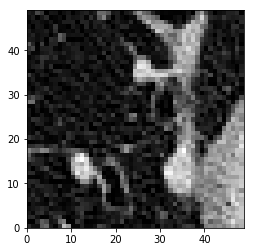

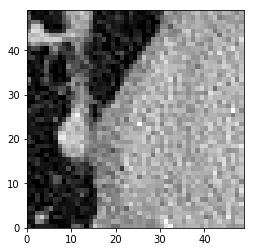

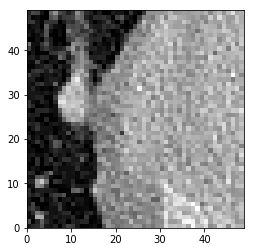

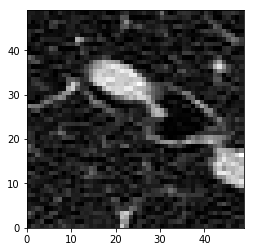

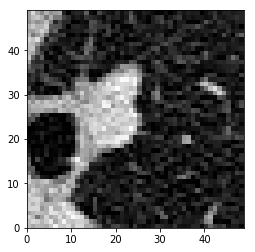

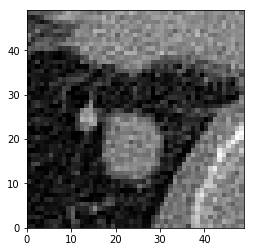

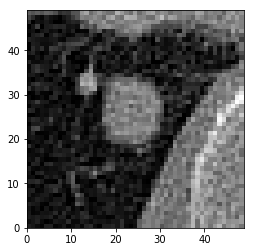

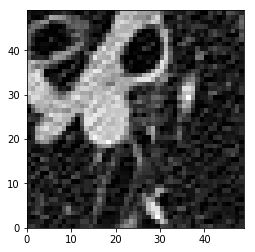

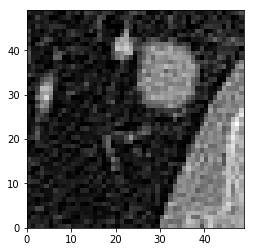

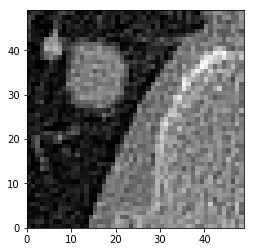

In [170]:
for i in range(10):
    plotArray(candidates[i,:,:,0],50,50)

In [ ]:
nb_tp=[]
nb_test=len(centroids_label)
for i in tqdm(range(nb_test)):
    testnumber=i
    testimage=ArrayDicom[:,:,testnumber].reshape(1,512,512,1)/1000
    prediction=screeningmodel.predict(testimage)
    #predictedlabel=np.argmax(prediction,axis=3)

    ###########################################
    #get candidates from screening model.
    tt=np.sort(prediction[0,:,:,0],axis=None)
    tt2=tt[::-1]
    xindices=np.where(prediction[0,:,:,0]>tt2[30])[0]
    yindices=np.where(prediction[0,:,:,0]>tt2[30])[1]

    kk=projectedCenter(xindices,yindices)
    xCoord, yCoord = kk
    
    ###########################################
    #test candidates using detecting model.

    prediction=detectModel.predict(X_test[0:387,:,:,:])

Export to images

In [34]:
def plotArrayWithbBoxSave(testimage,testnumber,xrange,yrange,xCoord,yCoord,xtop,ytop,size=50):
    l1=np.arange(xrange)
    l2=np.arange(yrange)
    fig=pyplot.figure()
    pyplot.axes().set_aspect('equal', 'datalim')
    pyplot.set_cmap(pyplot.gray())
    pyplot.pcolormesh(l1, l2, np.flipud(testimage))
    
    for i in range(len(xCoord)):
        rectangle = pyplot.Rectangle((yCoord[i]-size/2, 512-(xCoord[i]+size/2)), size, size, fill=False, color='r')
        pyplot.gca().add_patch(rectangle)
    
    rectangle = pyplot.Rectangle((ytop-size/2, 512-(xtop+size/2)), size, size, fill=False, color='g')
    pyplot.gca().add_patch(rectangle)
    
    pyplot.axis('scaled')
    #fig.savefig('G:/Jupyter_python/Beom/170217/screeningimages/benign/'+str(testnumber+1)+'.png')
    fig.savefig('G:/Jupyter_python/Beom/ForReport/images_mal/'+str(testnumber+1)+'.png')
    #pyplot.show()
    pyplot.close()

In [35]:
nb_test=len(lstFilesDCM)
for i in tqdm(range(nb_test)):
    testnumber=i
    testimage=ArrayDicom[:,:,testnumber].reshape(1,512,512,1)/1000
    prediction=screeningmodel.predict(testimage)
    #predictedlabel=np.argmax(prediction,axis=3)

    #i have to change this candidate measure.

    tt=np.sort(prediction[0,:,:,0],axis=None)
    tt2=tt[::-1]

    #top 10 candidates.
    xindices=np.where(prediction[0,:,:,0]>tt2[10])[0]
    yindices=np.where(prediction[0,:,:,0]>tt2[10])[1]

    #top candidate
    xtop=np.where(prediction[0,:,:,0]==prediction[0,:,:,0].max())[0]
    ytop=np.where(prediction[0,:,:,0]==prediction[0,:,:,0].max())[1]

    kk=projectedCenter(xindices,yindices)
    xCoord, yCoord = kk

    kk2=projectedCenter(xtop,ytop)
    xtop, ytop = kk2

    #xCoord, yCoord=projectedCenter(7,12)
    plotArrayWithbBoxSave(testimage[0,:,:,0],testnumber, 512, 512, xCoord, yCoord, xtop[0], ytop[0], size=46)

100%|██████████████████████████████████████| 1117/1117 [11:09<00:00,  1.64it/s]
